In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna

# ✅ Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [10]:
""" MODEL STUFF """

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])  # Last time step output


# Helper: Create sequences for LSTM
def create_sequences(data, dates, seq_len=30):
    X, y, y_dates = [], [], []
    data_array = data  # Already a NumPy array
    for i in range(len(data_array) - seq_len):
        X.append(data_array[i:i+seq_len])
        y.append(data_array[i+seq_len, 0])
        y_dates.append(dates[i+seq_len])
    return np.array(X), np.array(y), np.array(y_dates)

# Helper: Inverse scale predictions for VN-INDEX (first column)
def inverse_scale_predictions(predictions, scaler):
    num_features = scaler.min_.shape[0]
    dummy = np.zeros((predictions.shape[0], num_features))
    dummy[:, 0] = predictions.flatten()
    return scaler.inverse_transform(dummy)[:, 0]


# Training function only, returns both the model and the overall average training loss across all epochs
def train_model(params, X_train_tensor, y_train_tensor, epochs=20):
    model = LSTMModel(
        input_size=X_train_tensor.shape[2],
        hidden_size=params['hidden_size'],
        num_layers=params['num_layers'],
        dropout=params['dropout']
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    criterion = nn.MSELoss()
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)

    epoch_losses = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(batch_X), batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(train_loader)
        epoch_losses.append(avg_loss)
    overall_avg_loss = np.mean(epoch_losses)
    return model, overall_avg_loss


# Evaluation function (used after tuning)
def evaluate_model(model, test_loader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            val_loss += criterion(model(batch_X), batch_y).item()
    return val_loss / len(test_loader)


# Optuna objective: returns the overall average training loss and stores the trained model
def objective(trial, X_train_tensor, y_train_tensor):
    params = {
        'hidden_size': trial.suggest_categorical('hidden_size', [64, 128, 256]),
        'num_layers': trial.suggest_int('num_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.1, 0.5),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128])
    }
    model, overall_avg_loss = train_model(params, X_train_tensor, y_train_tensor, epochs=50)
    trial.set_user_attr("model", model)
    return overall_avg_loss


# Main pipeline
def lstm_model_pipeline(data, seq_len=30, tuning=True, best_params={'hidden_size': 128, 'num_layers': 2,
    'dropout': 0.3, 'learning_rate': 1e-4, 'batch_size': 32}):

    if isinstance(data, pd.Series):
        data = data.to_frame()

    train_size = int(0.9 * len(data))
    scaler = MinMaxScaler()
    scaler.fit(data[:train_size])
    data_scaled = scaler.transform(data)

    X, y, y_dates = create_sequences(data_scaled, data.index, seq_len)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    y_dates_train, y_dates_test = y_dates[:train_size], y_dates[train_size:]

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)

    if tuning:
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, X_train_tensor, y_train_tensor), n_trials=10)
        best_params = study.best_params
        print("Best Hyperparameters:", best_params)
        print(f"Best Overall Average Training Loss: {study.best_value:.4f}")
        final_model = study.best_trial.user_attrs["model"]
    else:
        final_model, overall_avg_loss = train_model(best_params, X_train_tensor, y_train_tensor, epochs=50)
        print(f"Overall Average Training Loss: {overall_avg_loss:.4f}")

    criterion = nn.MSELoss()
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

    val_loss = evaluate_model(final_model, test_loader, criterion)
    print(f"Final Evaluation Loss on Test Set: {val_loss:.4f}")

    final_model.eval()
    with torch.no_grad():
        y_pred_tensor = final_model(X_test_tensor).cpu().numpy()
        y_true_tensor = y_test_tensor.cpu().numpy()

    y_pred = inverse_scale_predictions(y_pred_tensor, scaler)
    y_true = inverse_scale_predictions(y_true_tensor, scaler)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    if len(y_true) > 1:
        directional_accuracy = np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred)))
    else:
        directional_accuracy = np.nan

    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}, Directional Accuracy: {directional_accuracy:.4f}")

    plt.figure(figsize=(12,6))
    plt.plot(y_dates_test, y_true, label="Actual VN-INDEX", marker='o', color="blue")
    plt.plot(y_dates_test, y_pred, label="Predicted VN-INDEX", marker='s', linestyle="dashed", color="red")
    plt.xlabel("Date")
    plt.ylabel("VN-INDEX")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.title("LSTM Predictions vs. Actual VN-INDEX")
    plt.show()

    results_df = pd.DataFrame({
        "Date": y_dates_test,
        "Actual VN-INDEX": y_true,
        "Predicted VN-INDEX": y_pred
    })
    print("Predicted vs. Actual VN-INDEX (Test Set):")
    print(results_df)

    data_for_prediction = np.array(data_scaled[-30:])
    return final_model, torch.tensor(data_for_prediction, dtype=torch.float32).to(device), scaler, y_pred


# Future Prediction Function
def future_prediction(X_test, y_pred, data, scaler, model, num_days=30):
    if isinstance(data, pd.Series):
        data = data.to_frame()

    model.eval()
    input_seq = X_test.cpu().numpy()
    future_preds = []
    for _ in range(num_days):
        input_tensor = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(input_tensor).cpu().numpy()[0, 0]
        future_preds.append(pred)
        input_seq = np.roll(input_seq, -1, axis=0)
        input_seq[-1, 0] = pred

    future_preds = inverse_scale_predictions(np.array(future_preds).reshape(-1,1), scaler)
    last_date = data.index[-1]
    future_dates = []
    while len(future_dates) < num_days:
        last_date += pd.Timedelta(days=1)
        if last_date.weekday() < 5:
            future_dates.append(last_date)

    plt.figure(figsize=(12,6))
    plt.plot(future_dates, future_preds, marker='o', linestyle="dashed", color="red", label="Predicted VN-INDEX")
    plt.xlabel("Date")
    plt.ylabel("VN-INDEX")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.title(f"Predicted VN-INDEX for Next {num_days} Trading Days")
    plt.show()

    historical_dates = data.index[-100:]
    historical_values = data.iloc[-100:, 0].values
    plt.figure(figsize=(12,6))
    plt.plot(historical_dates, historical_values, label="Historical VN-INDEX", color="blue")
    plt.plot(historical_dates, y_pred[-100:], label="Test Predictions", color="red")
    plt.plot(future_dates, future_preds, color="green", label="Future Predicted VN-INDEX")
    plt.xlabel("Date")
    plt.ylabel("VN-INDEX")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.title("Historical VN-INDEX with Future Predictions")
    plt.show()

    future_df = pd.DataFrame({"Date": future_dates, "Predicted VN-INDEX": future_preds})
    print(future_df)

In [3]:
# =============================================================================
# FEATURE ENGINEERING FUNCTIONS
# =============================================================================

def compute_RSI(series, window=14):
    """
    Compute the Relative Strength Index (RSI) for a time-series.
    
    Args:
        series (pd.Series): Series of prices.
        window (int): Window size.
    
    Returns:
        pd.Series: RSI values.
    """
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0).rolling(window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))


def lag_features_indicators(df, numerical_columns):
    """
    Generate lag features, moving averages, RSI, MACD, volatility, seasonality,
    and interaction features.
    
    Args:
        df (pd.DataFrame): Input data.
        numerical_columns (list): List of numerical column names.
    
    Returns:
        pd.DataFrame: DataFrame with additional features.
    """
    copy_df = df.copy()
    # Lagged Features
    lag_days = [1, 2, 3, 5, 10]
    for col in numerical_columns:
        for lag in lag_days:
            copy_df[f'{col}_Lag{lag}'] = copy_df[col].shift(lag)
    
    # Moving Averages and Exponential Moving Averages
    for col in numerical_columns:
        copy_df[f'{col}_SMA_10'] = copy_df[col].rolling(window=10).mean()
        copy_df[f'{col}_SMA_20'] = copy_df[col].rolling(window=20).mean()
        copy_df[f'{col}_EMA_10'] = copy_df[col].ewm(span=10, adjust=False).mean()
        copy_df[f'{col}_EMA_20'] = copy_df[col].ewm(span=20, adjust=False).mean()
    
    # Relative Strength Index (RSI)
    for col in numerical_columns:
        copy_df[f'{col}_RSI_14'] = compute_RSI(copy_df[col])
    
    # Moving Average Convergence Divergence (MACD)
    for col in numerical_columns:
        copy_df[f'{col}_EMA_12'] = copy_df[col].ewm(span=12, adjust=False).mean()
        copy_df[f'{col}_EMA_26'] = copy_df[col].ewm(span=26, adjust=False).mean()
        copy_df[f'{col}_MACD'] = copy_df[f'{col}_EMA_12'] - copy_df[f'{col}_EMA_26']
    
    # Additional Feature: Rolling Standard Deviation for Volatility
    for col in numerical_columns:
        copy_df[f'{col}_RollingStd_10'] = copy_df[col].rolling(window=10).std()
    
    # Seasonality Features: Day of Week and Month
    copy_df['DayOfWeek'] = copy_df.index.dayofweek
    copy_df['Month'] = copy_df.index.month
    
    # Interaction Feature: Ratio of EMA_10 to EMA_20
    for col in numerical_columns:
        copy_df[f'{col}_EMA_Ratio'] = copy_df[f'{col}_EMA_10'] / copy_df[f'{col}_EMA_20']
    
    # Drop NA values caused by shifting and rolling
    copy_df.dropna(inplace=True)
    
    return copy_df


def quicky_data(df):
    """
    Preprocess the data by converting the 'Date' column to datetime,
    setting it as index, and dropping unnecessary columns.
    
    Args:
        df (pd.DataFrame): Raw data.
    
    Returns:
        pd.DataFrame: Preprocessed data.
    """
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    if 'Index' in df.columns:
        df.drop(columns=['Index'], inplace=True)
    
    return df

def select_features_by_correlation(df, target_col="VN_Index_Close", train_ratio=0.9, corr_threshold=0.05):
    """
    Splits the DataFrame by time (first train_ratio% of rows is 'training'),
    calculates correlation of each feature with the target on TRAIN rows only,
    and returns the subset of columns (target + selected features).
    
    Args:
        df (pd.DataFrame): Full dataset (includes the target column).
        target_col (str): Target column name, default = "VN_Index_Close".
        train_ratio (float): Proportion of data used for 'training'.
        corr_threshold (float): Minimum absolute correlation needed to keep a feature.
    
    Returns:
        pd.DataFrame: A filtered DataFrame with only 'target_col' + selected features.
    """
    # Sort by index if needed (assuming your index is Date or similar)
    df = df.sort_index()
    n_train = int(len(df) * train_ratio)
    
    # TRAIN portion (first 90% by default)
    df_train = df.iloc[:n_train]
    
    # Identify all potential features (exclude the target itself)
    all_features = [col for col in df.columns if col != target_col]
    
    # Calculate absolute correlation with the target on the training portion only
    corr_series = df_train[all_features].corrwith(df_train[target_col]).abs()
    
    # Filter by threshold
    selected_features = corr_series[corr_series >= corr_threshold].index.tolist()
    
    print(f"Features with abs(corr) >= {corr_threshold}:")
    print(selected_features)
    
    # Return only target + selected features
    return df[[target_col] + selected_features]

In [4]:
# 📂 Load dataset
file_path_1 = "../ready_data/cleaned_hose_historical_data.csv"
df_1 = pd.read_csv(file_path_1)
df_1 = quicky_data(df_1)

[I 2025-04-03 23:19:27,009] A new study created in memory with name: no-name-5ce07691-1780-424b-9f53-b63cc6a5174e
[I 2025-04-03 23:20:54,235] Trial 0 finished with value: 0.0007989000768236564 and parameters: {'hidden_size': 64, 'num_layers': 3, 'dropout': 0.35165536609954995, 'learning_rate': 0.00217312016197925, 'batch_size': 32}. Best is trial 0 with value: 0.0007989000768236564.
/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2956697208567129 and num_layers=1
  warnings.warn(
[I 2025-04-03 23:21:14,559] Trial 1 finished with value: 0.003039986466837945 and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.2956697208567129, 'learning_rate': 0.0005396641051364546, 'batch_size': 64}. Best is trial 0 with value: 0.0007989000768236564.
[I 2025-04-03 23:22:24,383] Trial 2 finished with value: 0.002769922

Best Hyperparameters: {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.33532178884774755, 'learning_rate': 0.005170555454546362, 'batch_size': 64}
Best Overall Average Training Loss: 0.0005
Final Evaluation Loss on Test Set: 0.0001
RMSE: 12.1603, MAE: 8.1829, R²: 0.9645, Directional Accuracy: 0.5106


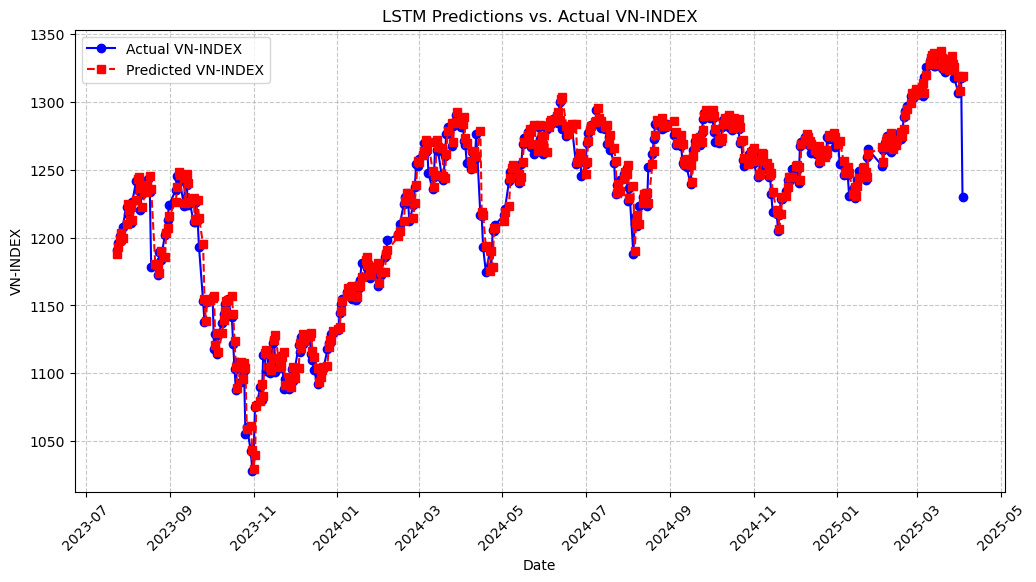

Predicted vs. Actual VN-INDEX (Test Set):
          Date  Actual VN-INDEX  Predicted VN-INDEX
0   2023-07-24      1190.719984         1187.753985
1   2023-07-25      1195.899982         1192.956950
2   2023-07-26      1200.839975         1198.300882
3   2023-07-27      1197.329994         1203.225229
4   2023-07-28      1207.670028         1199.751088
..         ...              ...                 ...
419 2025-03-28      1317.460022         1325.389753
420 2025-03-31      1306.860022         1318.822210
421 2025-04-01      1317.330000         1308.089027
422 2025-04-02      1317.829973         1318.492415
423 2025-04-03      1229.839993         1319.147073

[424 rows x 3 columns]


AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [ ]:
# 📊 Select only VN-INDEX for prediction
data = df_1["VN_Index_Close"]

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = lstm_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

[I 2025-04-03 23:45:39,459] A new study created in memory with name: no-name-903c8161-9334-495c-8507-a30378f8a289
[I 2025-04-03 23:48:21,718] Trial 0 finished with value: 0.0005989513810885683 and parameters: {'hidden_size': 128, 'num_layers': 3, 'dropout': 0.14780773283151288, 'learning_rate': 0.0027935487874582933, 'batch_size': 32}. Best is trial 0 with value: 0.0005989513810885683.
/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3901810369667889 and num_layers=1
  warnings.warn(
[I 2025-04-03 23:49:06,601] Trial 1 finished with value: 0.0010486504978814537 and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout': 0.3901810369667889, 'learning_rate': 0.00027289070225916594, 'batch_size': 32}. Best is trial 0 with value: 0.0005989513810885683.
[I 2025-04-03 23:49:57,197] Trial 2 finished with value: 0.003

Best Hyperparameters: {'hidden_size': 128, 'num_layers': 1, 'dropout': 0.45713246498277965, 'learning_rate': 0.0017151196404660827, 'batch_size': 32}
Best Overall Average Training Loss: 0.0004
Final Evaluation Loss on Test Set: 0.0003
RMSE: 21.4082, MAE: 17.9655, R²: 0.8899, Directional Accuracy: 0.5059


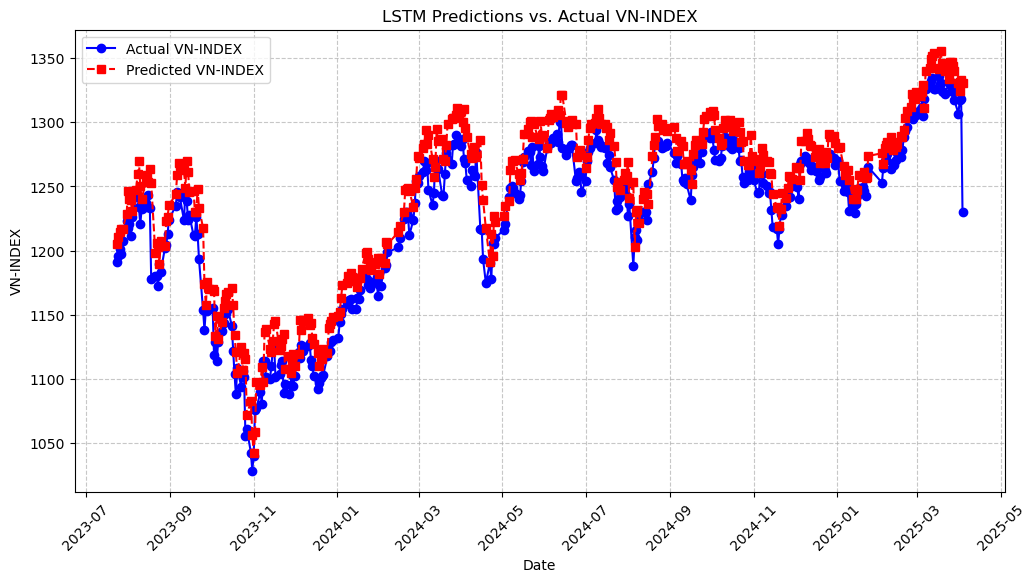

Predicted vs. Actual VN-INDEX (Test Set):
          Date  Actual VN-INDEX  Predicted VN-INDEX
0   2023-07-24      1190.719984         1205.292326
1   2023-07-25      1195.899982         1210.348160
2   2023-07-26      1200.839975         1214.690220
3   2023-07-27      1197.329994         1216.723097
4   2023-07-28      1207.670028         1216.606640
..         ...              ...                 ...
419 2025-03-28      1317.460022         1340.283489
420 2025-03-31      1306.860022         1330.611678
421 2025-04-01      1317.330000         1324.290153
422 2025-04-02      1317.829973         1332.859666
423 2025-04-03      1229.839993         1330.645976

[424 rows x 3 columns]


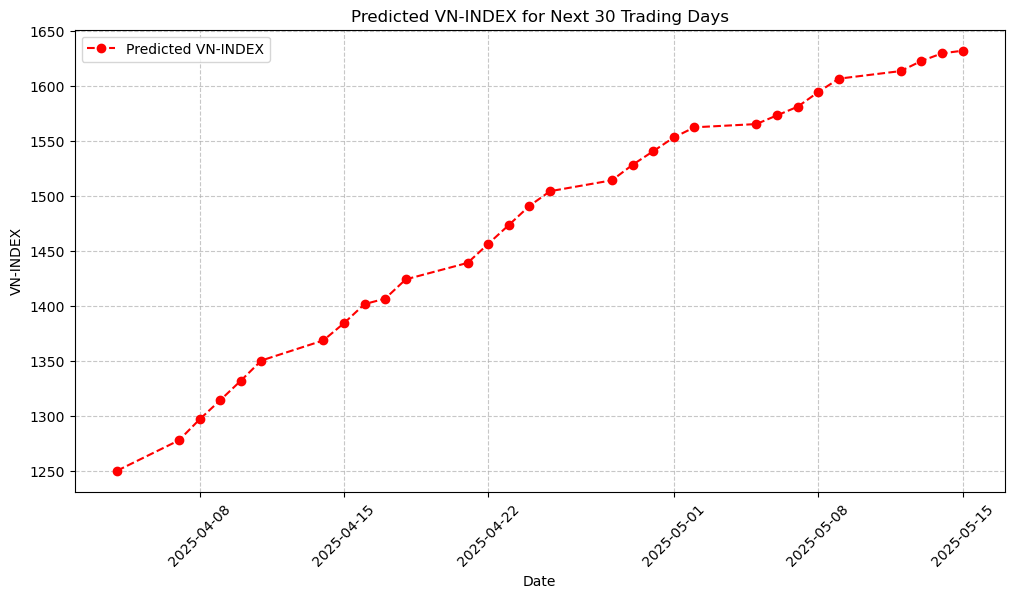

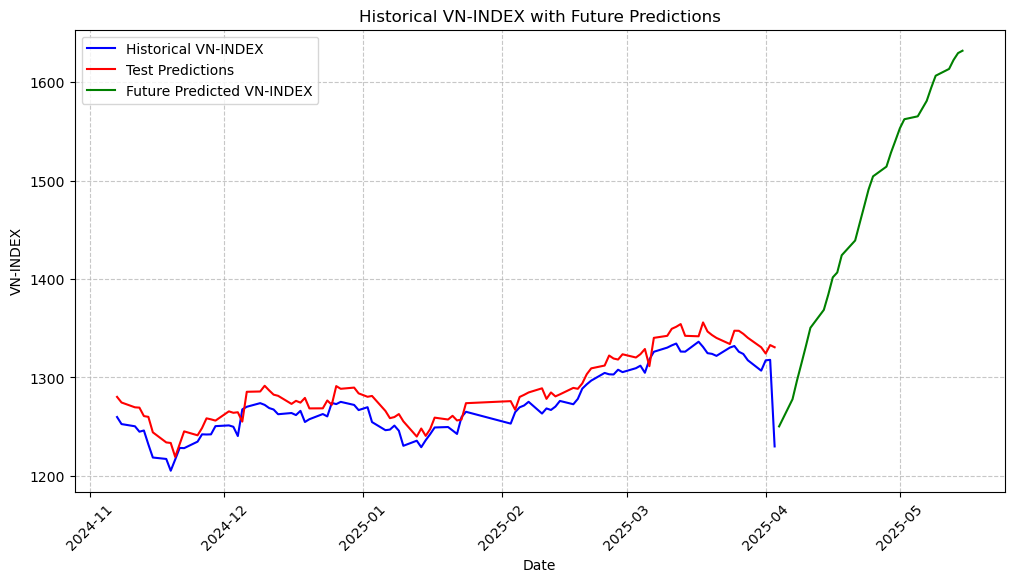

         Date  Predicted VN-INDEX
0  2025-04-04         1250.202982
1  2025-04-07         1277.830176
2  2025-04-08         1296.835756
3  2025-04-09         1314.239605
4  2025-04-10         1332.013405
5  2025-04-11         1350.408027
6  2025-04-14         1368.638098
7  2025-04-15         1384.253084
8  2025-04-16         1401.668263
9  2025-04-17         1406.648719
10 2025-04-18         1424.155845
11 2025-04-21         1439.145461
12 2025-04-22         1456.446263
13 2025-04-23         1473.601783
14 2025-04-24         1490.993224
15 2025-04-25         1504.337562
16 2025-04-28         1514.238896
17 2025-04-29         1528.319513
18 2025-04-30         1540.663983
19 2025-05-01         1553.190655
20 2025-05-02         1562.414132
21 2025-05-05         1565.357549
22 2025-05-06         1573.244119
23 2025-05-07         1581.068876
24 2025-05-08         1594.374446
25 2025-05-09         1606.621188
26 2025-05-12         1613.534480
27 2025-05-13         1622.658842
28 2025-05-14 

In [12]:
# 📊 Select additional VN-INDEX statistics for prediction
data = df_1

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = lstm_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

[I 2025-04-04 00:05:54,482] A new study created in memory with name: no-name-9380a9ff-509c-45ae-b0d9-f02e6a86c14c
[I 2025-04-04 00:06:39,322] Trial 0 finished with value: 0.0006424239625744121 and parameters: {'hidden_size': 64, 'num_layers': 2, 'dropout': 0.26525094133103044, 'learning_rate': 0.0019939509771582124, 'batch_size': 64}. Best is trial 0 with value: 0.0006424239625744121.
/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.23122036965561688 and num_layers=1
  warnings.warn(
[I 2025-04-04 00:08:09,144] Trial 1 finished with value: 0.0006996158344050553 and parameters: {'hidden_size': 256, 'num_layers': 1, 'dropout': 0.23122036965561688, 'learning_rate': 0.009825486026037986, 'batch_size': 32}. Best is trial 0 with value: 0.0006424239625744121.
[I 2025-04-04 00:13:17,164] Trial 2 finished with value: 0.0193

Best Hyperparameters: {'hidden_size': 128, 'num_layers': 1, 'dropout': 0.3887230830948357, 'learning_rate': 0.002648392245518272, 'batch_size': 32}
Best Overall Average Training Loss: 0.0002
Final Evaluation Loss on Test Set: 0.0002
RMSE: 15.4315, MAE: 11.3827, R²: 0.9430, Directional Accuracy: 0.4941


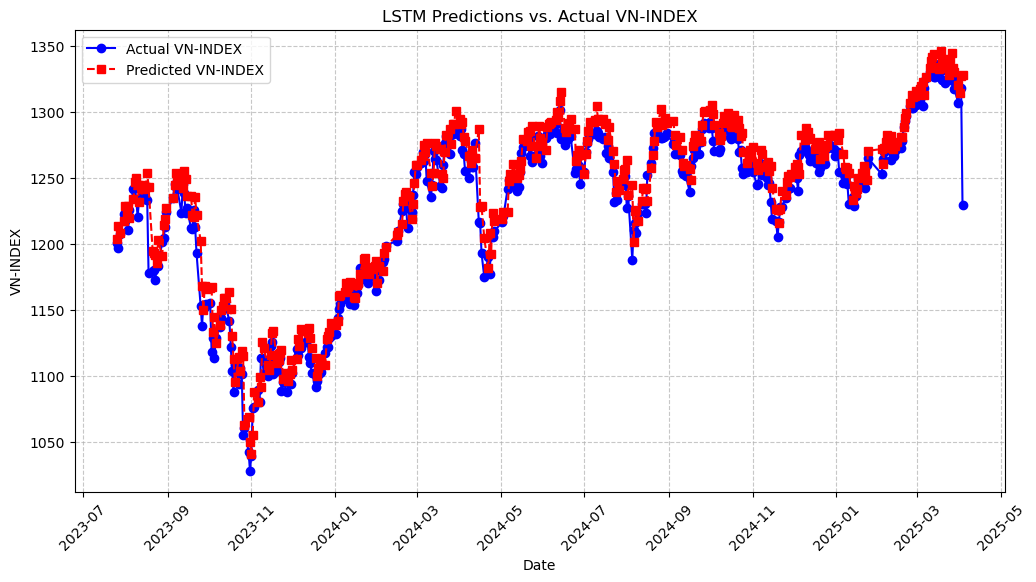

Predicted vs. Actual VN-INDEX (Test Set):
          Date  Actual VN-INDEX  Predicted VN-INDEX
0   2023-07-26      1200.839975         1203.648360
1   2023-07-27      1197.329994         1213.271923
2   2023-07-28      1207.670028         1208.422800
3   2023-07-31      1222.900034         1217.139291
4   2023-08-01      1217.560032         1228.484973
..         ...              ...                 ...
417 2025-03-28      1317.460022         1330.562583
418 2025-03-31      1306.860022         1320.646990
419 2025-04-01      1317.330000         1314.756996
420 2025-04-02      1317.829973         1327.581631
421 2025-04-03      1229.839993         1328.181105

[422 rows x 3 columns]


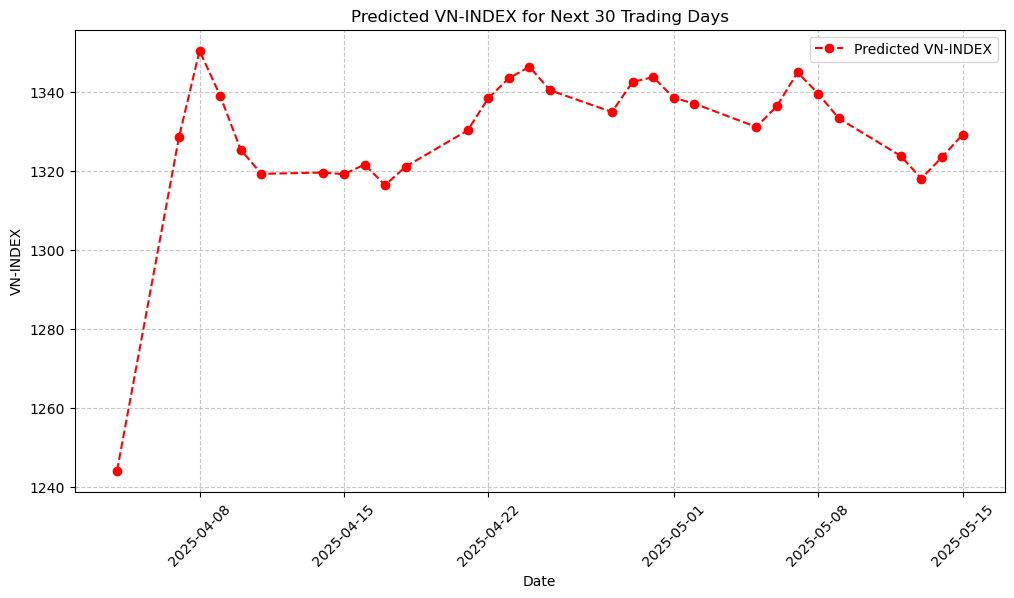

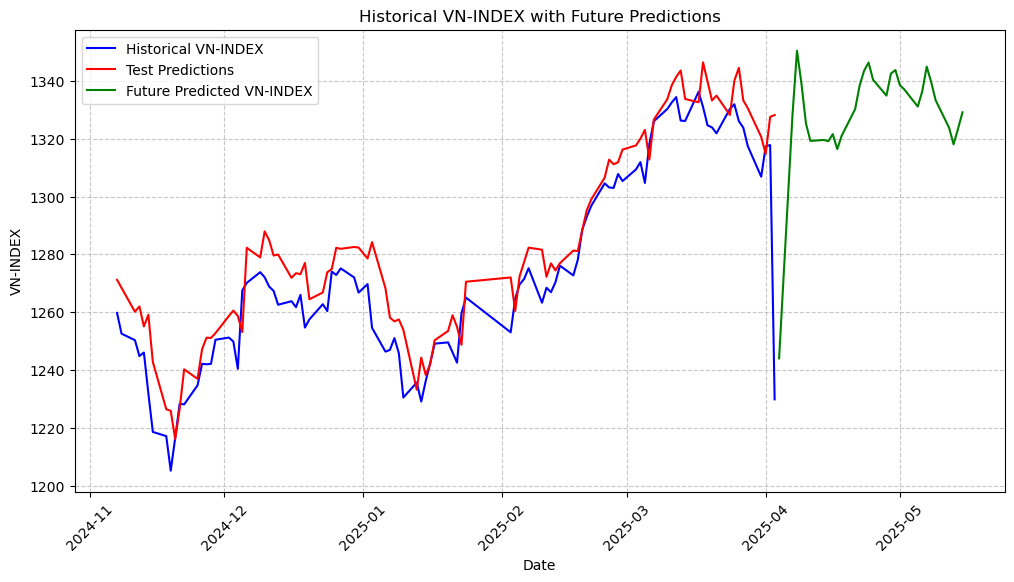

         Date  Predicted VN-INDEX
0  2025-04-04         1244.011555
1  2025-04-07         1328.461265
2  2025-04-08         1350.448567
3  2025-04-09         1339.038221
4  2025-04-10         1325.314838
5  2025-04-11         1319.242181
6  2025-04-14         1319.582535
7  2025-04-15         1319.153701
8  2025-04-16         1321.596375
9  2025-04-17         1316.417456
10 2025-04-18         1321.084919
11 2025-04-21         1330.258376
12 2025-04-22         1338.378014
13 2025-04-23         1343.510766
14 2025-04-24         1346.354142
15 2025-04-25         1340.421527
16 2025-04-28         1334.918516
17 2025-04-29         1342.549974
18 2025-04-30         1343.757014
19 2025-05-01         1338.509886
20 2025-05-02         1337.038332
21 2025-05-05         1331.130534
22 2025-05-06         1336.414195
23 2025-05-07         1344.949410
24 2025-05-08         1339.588445
25 2025-05-09         1333.295128
26 2025-05-12         1323.808601
27 2025-05-13         1318.065277
28 2025-05-14 

In [13]:
# 📊 Select additional VN-INDEX statistics for prediction
data = lag_features_indicators(df_1[['VN_Index_Close']], ['VN_Index_Close'])

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = lstm_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

[I 2025-04-04 00:25:45,623] A new study created in memory with name: no-name-6d8d4c30-296b-43bb-b973-58f171509cbd
/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.16585260925203232 and num_layers=1
  warnings.warn(
[I 2025-04-04 00:27:31,426] Trial 0 finished with value: 0.00027258407055428044 and parameters: {'hidden_size': 256, 'num_layers': 1, 'dropout': 0.16585260925203232, 'learning_rate': 0.003633329183531052, 'batch_size': 32}. Best is trial 0 with value: 0.00027258407055428044.
[I 2025-04-04 00:30:34,350] Trial 1 finished with value: 0.0017560437367274062 and parameters: {'hidden_size': 256, 'num_layers': 2, 'dropout': 0.24866018772915016, 'learning_rate': 0.0031021032384755723, 'batch_size': 128}. Best is trial 0 with value: 0.00027258407055428044.
/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modul

Best Hyperparameters: {'hidden_size': 128, 'num_layers': 1, 'dropout': 0.37025038562963153, 'learning_rate': 0.0018409768184232055, 'batch_size': 64}
Best Overall Average Training Loss: 0.0003
Final Evaluation Loss on Test Set: 0.0001
RMSE: 14.0369, MAE: 10.0022, R²: 0.9528, Directional Accuracy: 0.5273


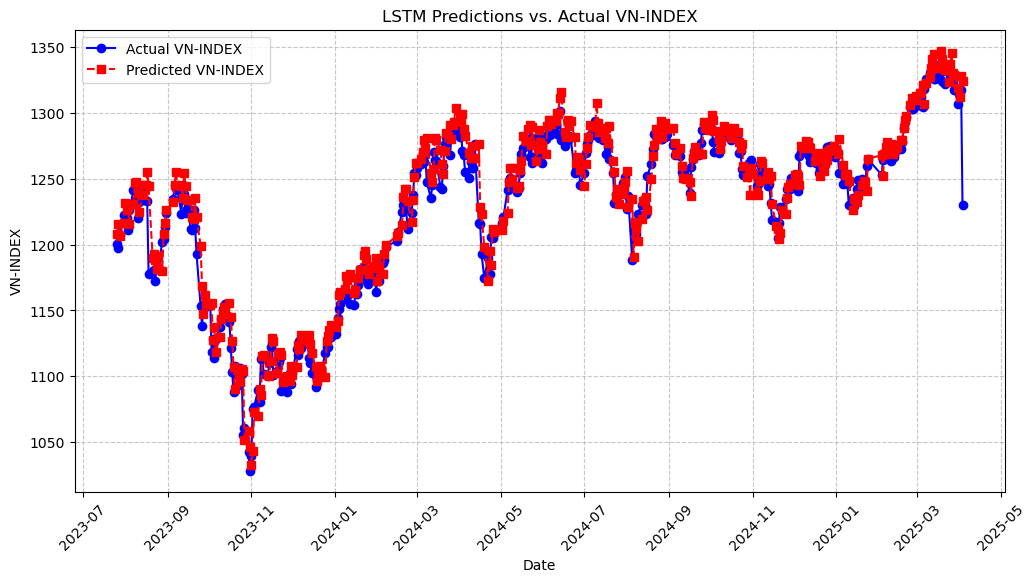

Predicted vs. Actual VN-INDEX (Test Set):
          Date  Actual VN-INDEX  Predicted VN-INDEX
0   2023-07-26      1200.839975         1208.181022
1   2023-07-27      1197.329994         1215.923311
2   2023-07-28      1207.670028         1206.459442
3   2023-07-31      1222.900034         1216.442937
4   2023-08-01      1217.560032         1231.893602
..         ...              ...                 ...
417 2025-03-28      1317.460022         1328.784972
418 2025-03-31      1306.860022         1318.926721
419 2025-04-01      1317.330000         1312.281027
420 2025-04-02      1317.829973         1327.893777
421 2025-04-03      1229.839993         1324.578406

[422 rows x 3 columns]


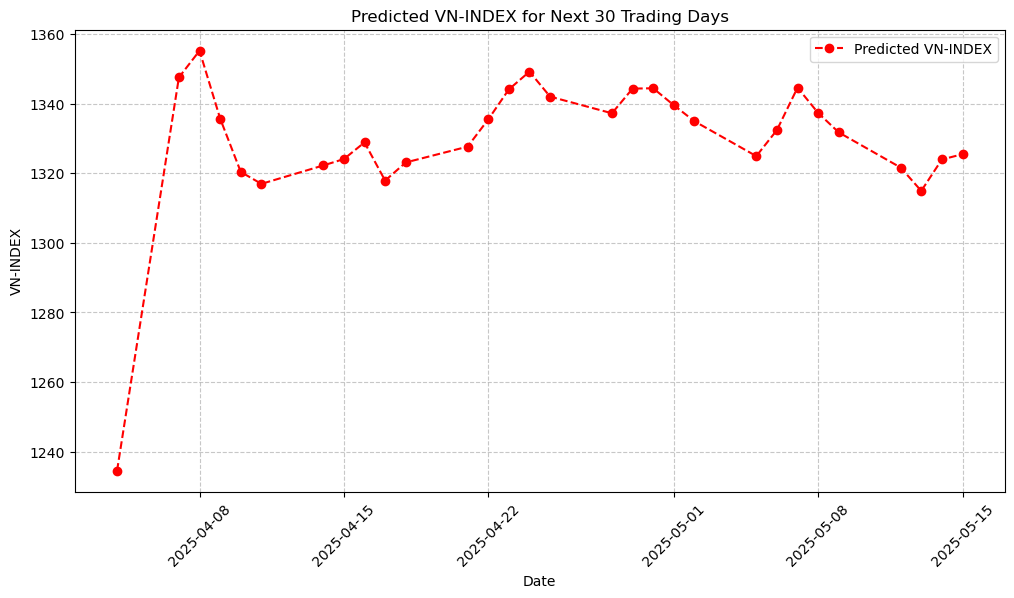

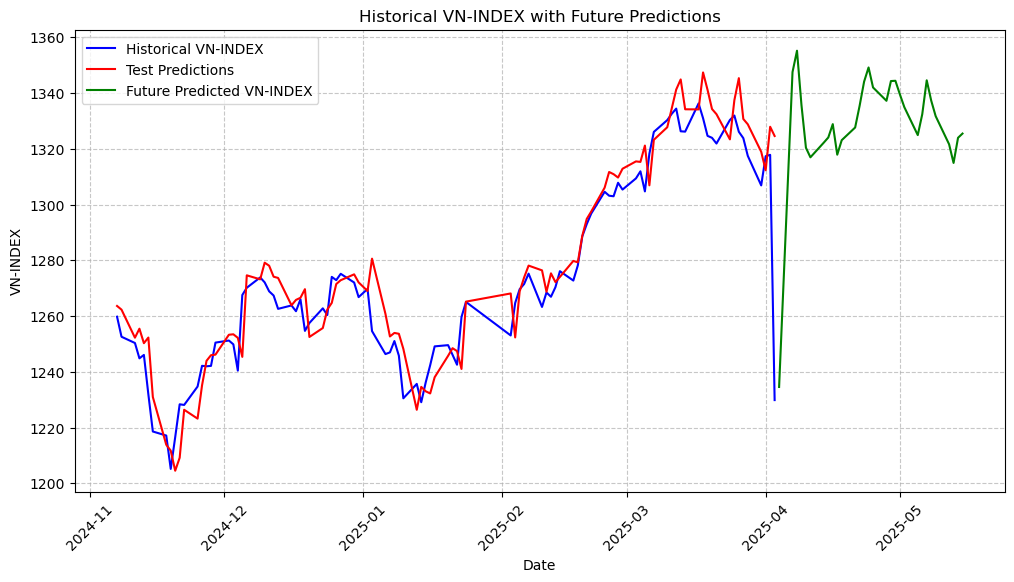

         Date  Predicted VN-INDEX
0  2025-04-04         1234.549691
1  2025-04-07         1347.511470
2  2025-04-08         1355.173064
3  2025-04-09         1335.684853
4  2025-04-10         1320.364903
5  2025-04-11         1316.934462
6  2025-04-14         1322.225136
7  2025-04-15         1324.054464
8  2025-04-16         1328.841775
9  2025-04-17         1317.873827
10 2025-04-18         1323.083036
11 2025-04-21         1327.627181
12 2025-04-22         1335.427892
13 2025-04-23         1344.068697
14 2025-04-24         1349.166612
15 2025-04-25         1341.992891
16 2025-04-28         1337.209202
17 2025-04-29         1344.292209
18 2025-04-30         1344.391402
19 2025-05-01         1339.522008
20 2025-05-02         1334.914277
21 2025-05-05         1324.904733
22 2025-05-06         1332.382122
23 2025-05-07         1344.569286
24 2025-05-08         1337.295370
25 2025-05-09         1331.707502
26 2025-05-12         1321.622272
27 2025-05-13         1314.913685
28 2025-05-14 

In [14]:
# 📊 Select additional VN-INDEX statistics for prediction
data = lag_features_indicators(df_1, ['VN_Index_Close'])

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = lstm_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

/var/folders/fl/t1q3j3rn0dg278fhg2bvg0dw0000gn/T/ipykernel_88644/3744217377.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy_df['Month'] = copy_df.index.month
/var/folders/fl/t1q3j3rn0dg278fhg2bvg0dw0000gn/T/ipykernel_88644/3744217377.py:69: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy_df[f'{col}_EMA_Ratio'] = copy_df[f'{col}_EMA_10'] / copy_df[f'{col}_EMA_20']
/var/folders/fl/t1q3j3rn0dg278fhg2bvg0dw0000gn/T/ipykernel_88644/3744217377.py:69: PerformanceWarning: DataFrame is highly fragmented.  This is usually the

Best Hyperparameters: {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.12392226290309485, 'learning_rate': 0.007465547800830922, 'batch_size': 32}
Best Overall Average Training Loss: 0.0003
Final Evaluation Loss on Test Set: 0.0003
RMSE: 19.9165, MAE: 15.0551, R²: 0.9050, Directional Accuracy: 0.5083


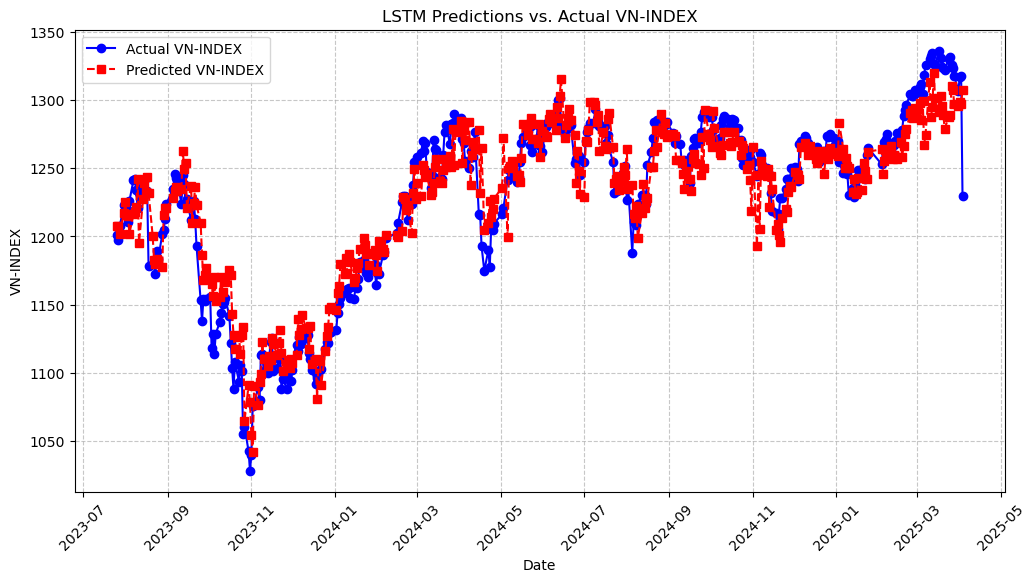

Predicted vs. Actual VN-INDEX (Test Set):
          Date  Actual VN-INDEX  Predicted VN-INDEX
0   2023-07-26      1200.839975         1207.588176
1   2023-07-27      1197.329994         1207.906950
2   2023-07-28      1207.670028         1201.702729
3   2023-07-31      1222.900034         1217.350240
4   2023-08-01      1217.560032         1225.628648
..         ...              ...                 ...
417 2025-03-28      1317.460022         1296.978033
418 2025-03-31      1306.860022         1295.768604
419 2025-04-01      1317.330000         1298.920272
420 2025-04-02      1317.829973         1297.335805
421 2025-04-03      1229.839993         1307.537647

[422 rows x 3 columns]


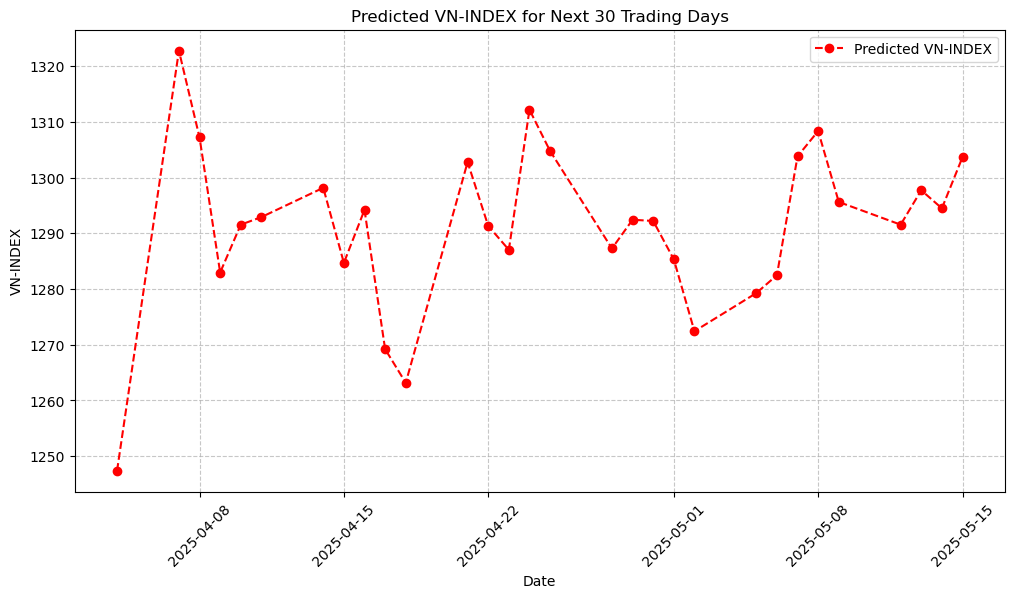

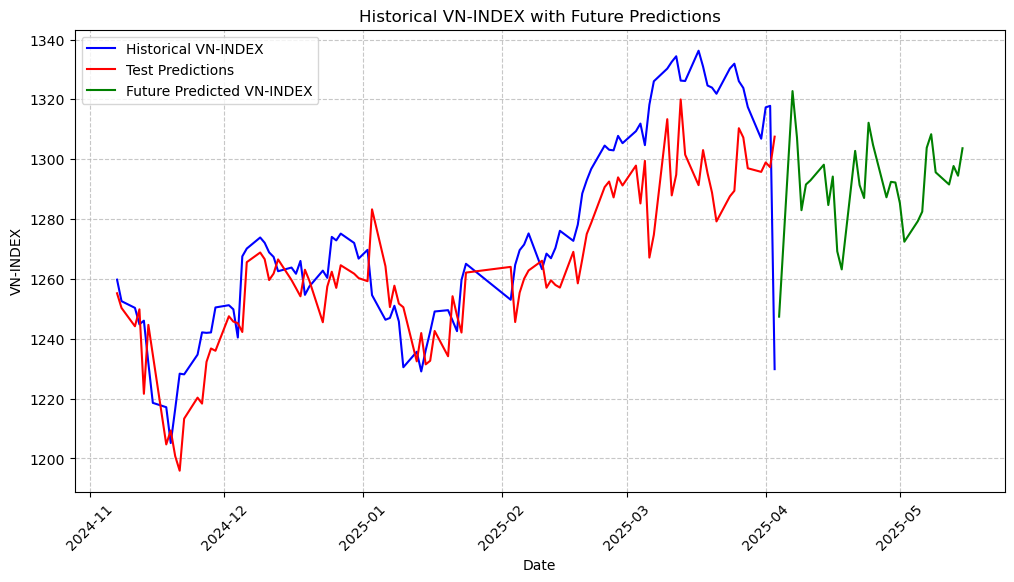

         Date  Predicted VN-INDEX
0  2025-04-04         1247.391437
1  2025-04-07         1322.770967
2  2025-04-08         1307.205309
3  2025-04-09         1282.963545
4  2025-04-10         1291.551633
5  2025-04-11         1292.914591
6  2025-04-14         1298.168348
7  2025-04-15         1284.689671
8  2025-04-16         1294.208184
9  2025-04-17         1269.212492
10 2025-04-18         1263.168429
11 2025-04-21         1302.780241
12 2025-04-22         1291.334441
13 2025-04-23         1287.040705
14 2025-04-24         1312.183761
15 2025-04-25         1304.774735
16 2025-04-28         1287.276395
17 2025-04-29         1292.437509
18 2025-04-30         1292.217389
19 2025-05-01         1285.325986
20 2025-05-02         1272.425048
21 2025-05-05         1279.273445
22 2025-05-06         1282.479372
23 2025-05-07         1303.815177
24 2025-05-08         1308.358937
25 2025-05-09         1295.626019
26 2025-05-12         1291.553791
27 2025-05-13         1297.724562
28 2025-05-14 

In [15]:
# 📊 Select additional VN-INDEX statistics for prediction
data = lag_features_indicators(df_1, df_1.columns)

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = lstm_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

In [16]:
# 📂 Load dataset
file_path_2 = "../ready_data/vn_index_external_data.csv"
df_2 = pd.read_csv(file_path_2)
df_2 = quicky_data(df_2)

[I 2025-04-04 00:52:07,515] A new study created in memory with name: no-name-c6c41b75-cd96-43ac-8296-40c87ef7c42c
/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.36902089848237185 and num_layers=1
  warnings.warn(
[I 2025-04-04 00:53:40,238] Trial 0 finished with value: 0.0014431813154419616 and parameters: {'hidden_size': 256, 'num_layers': 1, 'dropout': 0.36902089848237185, 'learning_rate': 0.00012772239750992112, 'batch_size': 64}. Best is trial 0 with value: 0.0014431813154419616.
/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1645601149424672 and num_layers=1
  warnings.warn(
[I 2025-04-04 00:55:06,085] Trial 1 finished with value: 0.00

Best Hyperparameters: {'hidden_size': 256, 'num_layers': 1, 'dropout': 0.1645601149424672, 'learning_rate': 0.005541900171518082, 'batch_size': 64}
Best Overall Average Training Loss: 0.0005
Final Evaluation Loss on Test Set: 0.0003
RMSE: 23.0645, MAE: 20.3661, R²: 0.8722, Directional Accuracy: 0.5177


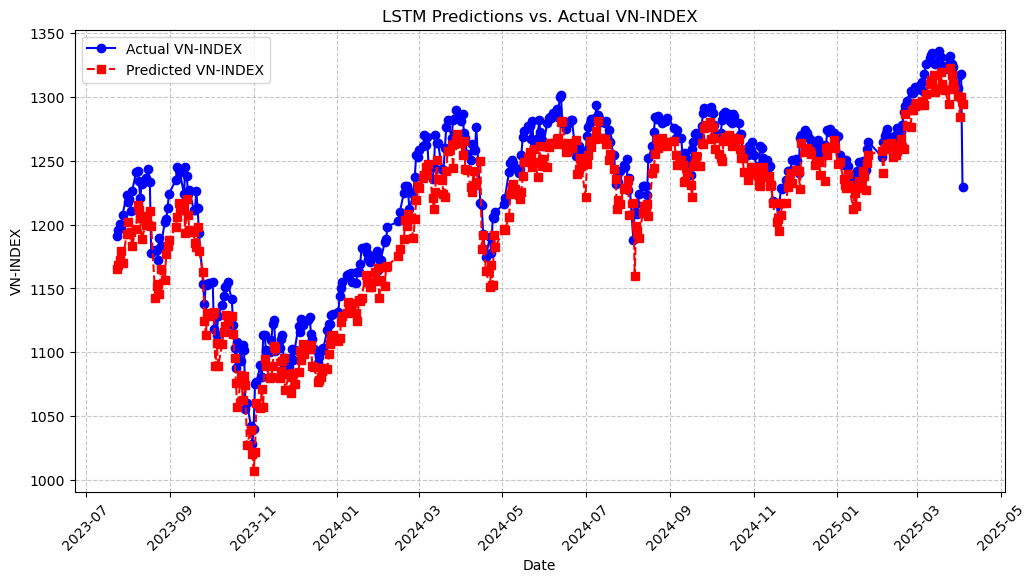

Predicted vs. Actual VN-INDEX (Test Set):
          Date  Actual VN-INDEX  Predicted VN-INDEX
0   2023-07-24      1190.719984         1165.479971
1   2023-07-25      1195.899982         1168.590020
2   2023-07-26      1200.839975         1172.127670
3   2023-07-27      1197.329994         1179.128671
4   2023-07-28      1207.670028         1170.217493
..         ...              ...                 ...
419 2025-03-28      1317.460022         1306.631809
420 2025-03-31      1306.860022         1301.084558
421 2025-04-01      1317.330000         1284.017980
422 2025-04-02      1317.829973         1300.255253
423 2025-04-03      1229.839993         1294.856753

[424 rows x 3 columns]


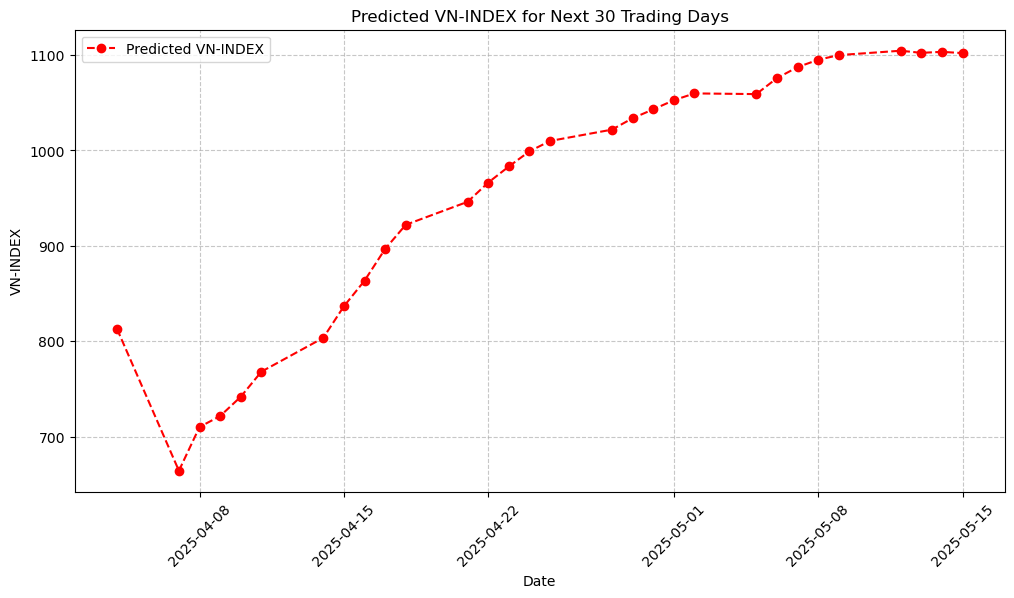

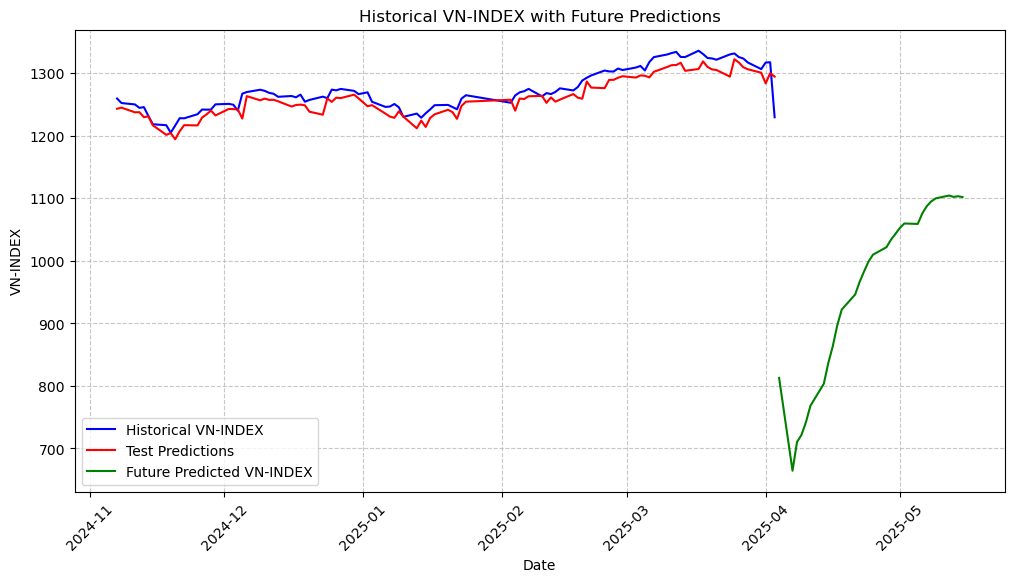

         Date  Predicted VN-INDEX
0  2025-04-04          812.846973
1  2025-04-07          664.273547
2  2025-04-08          710.143145
3  2025-04-09          721.586209
4  2025-04-10          741.841411
5  2025-04-11          768.136245
6  2025-04-14          803.550662
7  2025-04-15          836.648419
8  2025-04-16          863.446886
9  2025-04-17          896.771122
10 2025-04-18          922.109789
11 2025-04-21          946.196019
12 2025-04-22          966.357000
13 2025-04-23          983.239450
14 2025-04-24          999.133671
15 2025-04-25         1009.991481
16 2025-04-28         1021.872512
17 2025-04-29         1033.800788
18 2025-04-30         1043.101262
19 2025-05-01         1052.694535
20 2025-05-02         1059.844827
21 2025-05-05         1059.122807
22 2025-05-06         1075.824444
23 2025-05-07         1087.384928
24 2025-05-08         1095.112959
25 2025-05-09         1099.996149
26 2025-05-12         1104.596712
27 2025-05-13         1102.372232
28 2025-05-14 

In [17]:
data = df_2

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = lstm_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

[I 2025-04-04 01:14:39,743] A new study created in memory with name: no-name-ce23e1a1-91e9-4402-b378-831e27681287
[I 2025-04-04 01:15:37,632] Trial 0 finished with value: 0.0037479597185665625 and parameters: {'hidden_size': 64, 'num_layers': 3, 'dropout': 0.38230122620425405, 'learning_rate': 0.00035269090203084586, 'batch_size': 128}. Best is trial 0 with value: 0.0037479597185665625.
[I 2025-04-04 01:17:27,690] Trial 1 finished with value: 0.0014197594591947621 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout': 0.4823947141165266, 'learning_rate': 0.00010011405245482916, 'batch_size': 32}. Best is trial 1 with value: 0.0014197594591947621.
[I 2025-04-04 01:18:48,224] Trial 2 finished with value: 0.0007076633360588858 and parameters: {'hidden_size': 128, 'num_layers': 2, 'dropout': 0.4498937146204143, 'learning_rate': 0.007332622412645023, 'batch_size': 64}. Best is trial 2 with value: 0.0007076633360588858.
[I 2025-04-04 01:23:57,248] Trial 3 finished with value: 0.000

Best Hyperparameters: {'hidden_size': 128, 'num_layers': 3, 'dropout': 0.10795436383410842, 'learning_rate': 0.0034513251962529413, 'batch_size': 32}
Best Overall Average Training Loss: 0.0004
Final Evaluation Loss on Test Set: 0.0005
RMSE: 29.3316, MAE: 26.4045, R²: 0.7940, Directional Accuracy: 0.5036


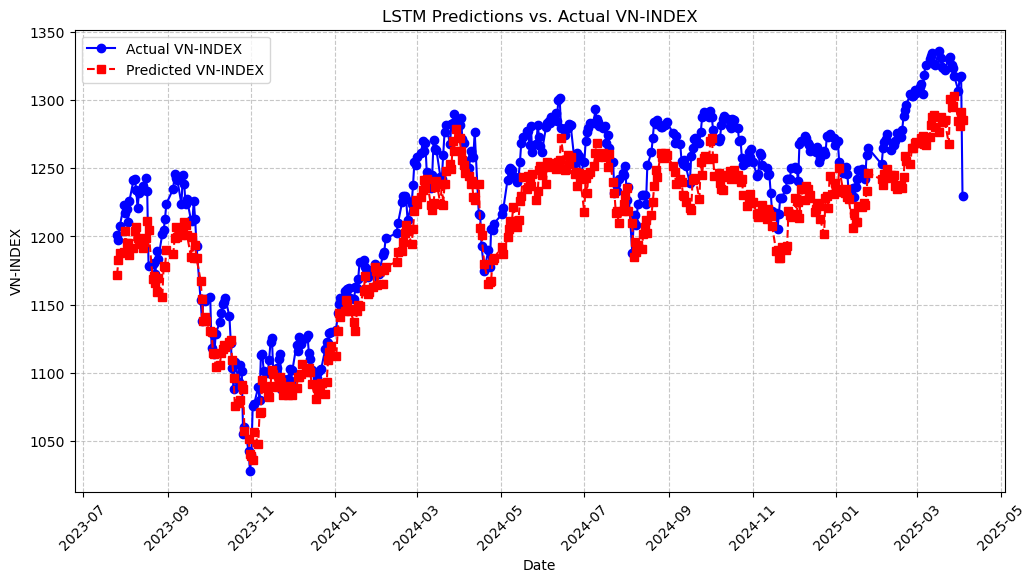

Predicted vs. Actual VN-INDEX (Test Set):
          Date  Actual VN-INDEX  Predicted VN-INDEX
0   2023-07-26      1200.839975         1171.778760
1   2023-07-27      1197.329994         1182.776072
2   2023-07-28      1207.670028         1188.044627
3   2023-07-31      1222.900034         1188.313381
4   2023-08-01      1217.560032         1204.016075
..         ...              ...                 ...
417 2025-03-28      1317.460022         1302.819008
418 2025-03-31      1306.860022         1284.414752
419 2025-04-01      1317.330000         1281.000419
420 2025-04-02      1317.829973         1291.267927
421 2025-04-03      1229.839993         1285.411845

[422 rows x 3 columns]


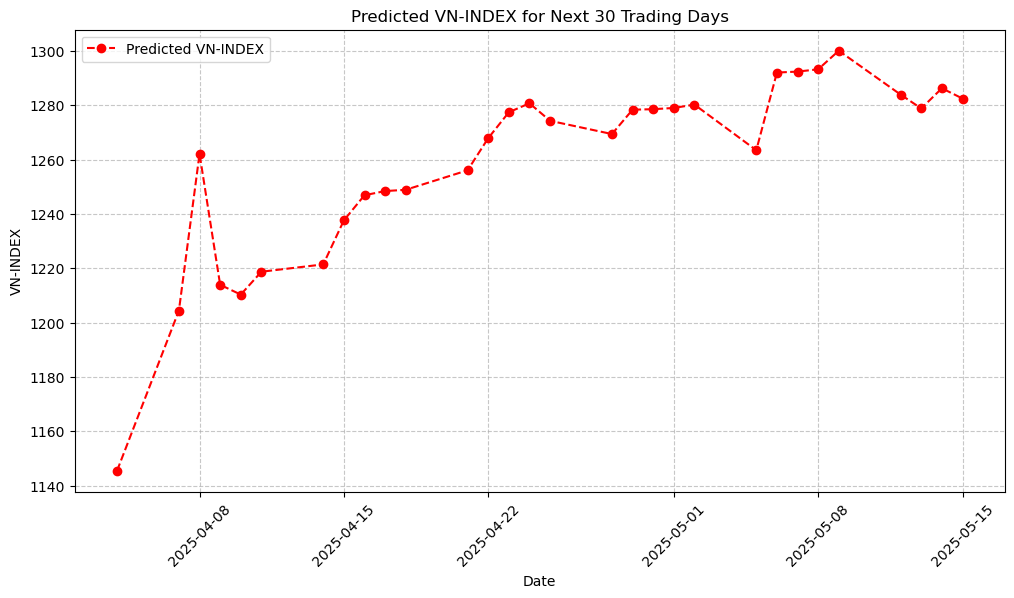

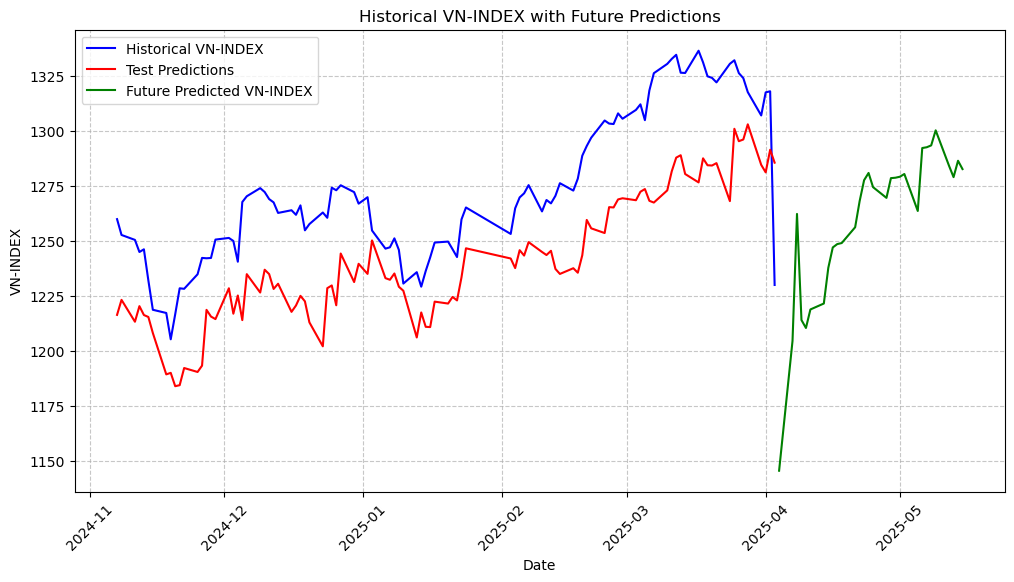

         Date  Predicted VN-INDEX
0  2025-04-04         1145.455718
1  2025-04-07         1204.422789
2  2025-04-08         1262.116615
3  2025-04-09         1213.907929
4  2025-04-10         1210.306463
5  2025-04-11         1218.720366
6  2025-04-14         1221.415454
7  2025-04-15         1237.636079
8  2025-04-16         1246.891927
9  2025-04-17         1248.415274
10 2025-04-18         1248.891739
11 2025-04-21         1256.066386
12 2025-04-22         1267.900171
13 2025-04-23         1277.439339
14 2025-04-24         1280.732436
15 2025-04-25         1274.284126
16 2025-04-28         1269.413730
17 2025-04-29         1278.377934
18 2025-04-30         1278.562909
19 2025-05-01         1279.014017
20 2025-05-02         1280.252195
21 2025-05-05         1263.455526
22 2025-05-06         1292.054534
23 2025-05-07         1292.402210
24 2025-05-08         1293.247007
25 2025-05-09         1300.089546
26 2025-05-12         1283.925493
27 2025-05-13         1278.832973
28 2025-05-14 

In [18]:
data = lag_features_indicators(df_2, ['VN_Index_Close'])

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = lstm_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

/var/folders/fl/t1q3j3rn0dg278fhg2bvg0dw0000gn/T/ipykernel_88644/3744217377.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy_df[f'{col}_Lag{lag}'] = copy_df[col].shift(lag)
/var/folders/fl/t1q3j3rn0dg278fhg2bvg0dw0000gn/T/ipykernel_88644/3744217377.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy_df[f'{col}_Lag{lag}'] = copy_df[col].shift(lag)
/var/folders/fl/t1q3j3rn0dg278fhg2bvg0dw0000gn/T/ipykernel_88644/3744217377.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

Best Hyperparameters: {'hidden_size': 256, 'num_layers': 3, 'dropout': 0.2506157698048611, 'learning_rate': 0.0003909861139665115, 'batch_size': 32}
Best Overall Average Training Loss: 0.0007
Final Evaluation Loss on Test Set: 0.0009
RMSE: 39.5367, MAE: 31.0744, R²: 0.6305, Directional Accuracy: 0.5205


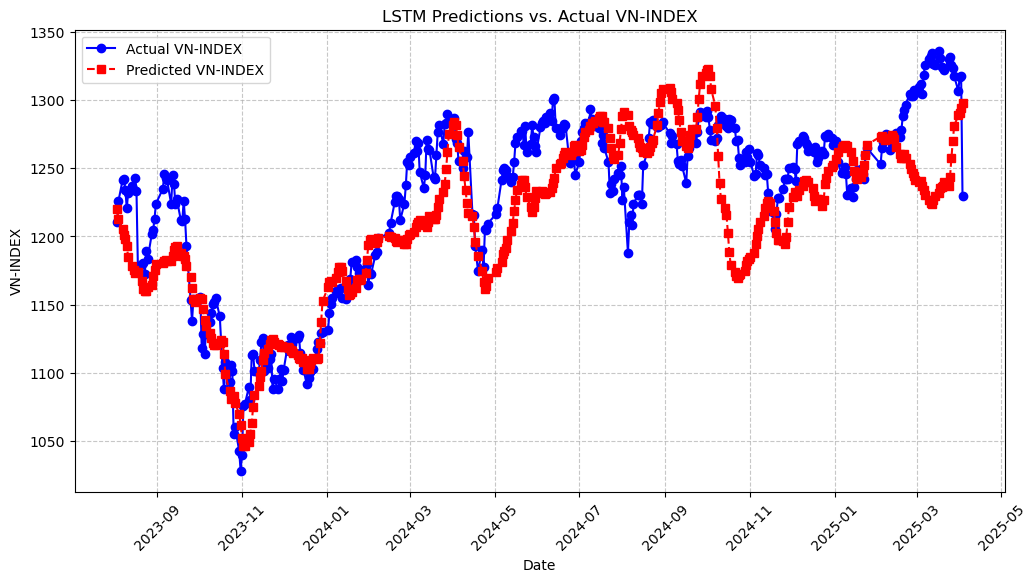

Predicted vs. Actual VN-INDEX (Test Set):
          Date  Actual VN-INDEX  Predicted VN-INDEX
0   2023-08-03      1210.950022         1220.222595
1   2023-08-04      1225.980024         1212.990992
2   2023-08-07      1241.419977         1205.436145
3   2023-08-08      1242.230014         1201.295091
4   2023-08-09      1233.989987         1197.877289
..         ...              ...                 ...
411 2025-03-28      1317.460022         1281.274413
412 2025-03-31      1306.860022         1288.877971
413 2025-04-01      1317.330000         1290.856357
414 2025-04-02      1317.829973         1294.076620
415 2025-04-03      1229.839993         1297.842560

[416 rows x 3 columns]


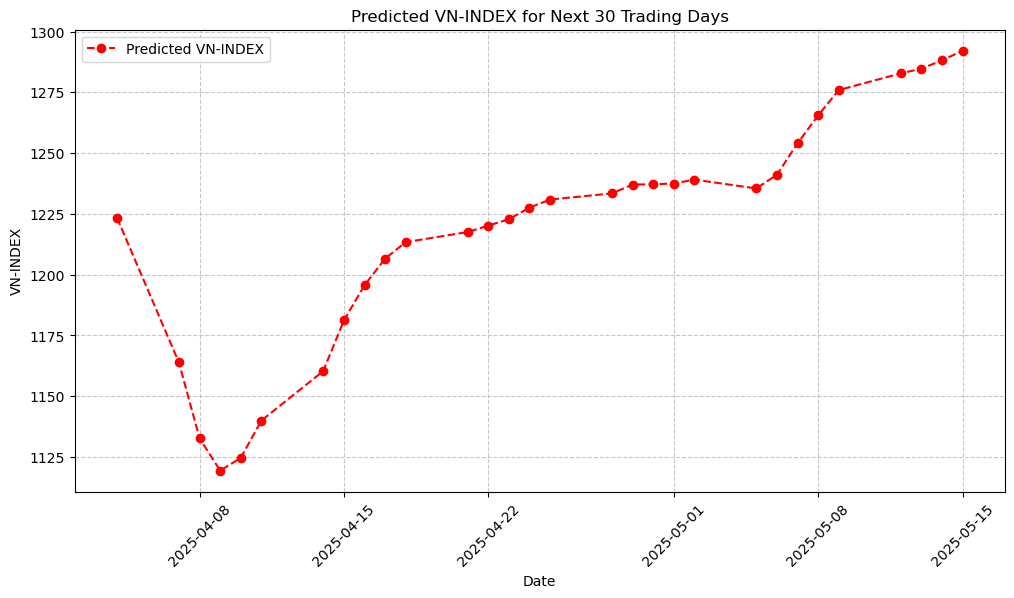

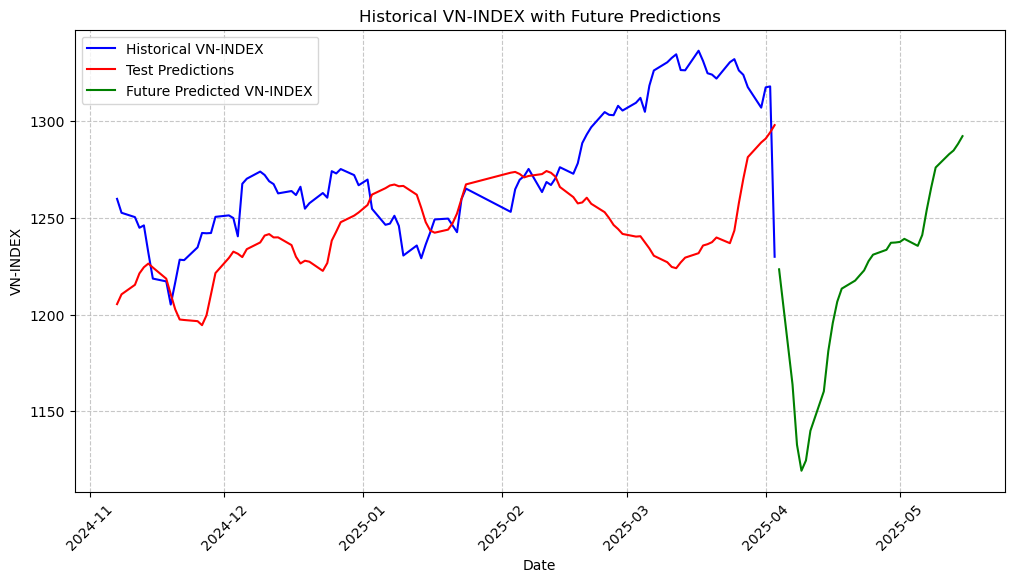

         Date  Predicted VN-INDEX
0  2025-04-04         1223.355997
1  2025-04-07         1163.880245
2  2025-04-08         1132.744842
3  2025-04-09         1119.334453
4  2025-04-10         1124.627979
5  2025-04-11         1139.971205
6  2025-04-14         1160.328259
7  2025-04-15         1181.152530
8  2025-04-16         1195.635853
9  2025-04-17         1206.636017
10 2025-04-18         1213.373274
11 2025-04-21         1217.531824
12 2025-04-22         1220.185138
13 2025-04-23         1222.793365
14 2025-04-24         1227.585994
15 2025-04-25         1230.912232
16 2025-04-28         1233.436218
17 2025-04-29         1237.065276
18 2025-04-30         1237.203468
19 2025-05-01         1237.509910
20 2025-05-02         1239.095533
21 2025-05-05         1235.483816
22 2025-05-06         1241.095114
23 2025-05-07         1254.024568
24 2025-05-08         1265.560389
25 2025-05-09         1275.951522
26 2025-05-12         1282.813715
27 2025-05-13         1284.735838
28 2025-05-14 

In [19]:
data = lag_features_indicators(df_2, df_2.columns)

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = lstm_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

In [20]:
# 📂 Load dataset
file_path_3 = "../ready_data/merged_data.csv"
df_3 = pd.read_csv(file_path_3)
df_3 = quicky_data(df_3)

[I 2025-04-04 02:02:55,426] A new study created in memory with name: no-name-51346409-8e20-4d7d-9760-c81d71a768a0
[I 2025-04-04 02:05:58,371] Trial 0 finished with value: 0.0025668052786932093 and parameters: {'hidden_size': 256, 'num_layers': 2, 'dropout': 0.3564442448942318, 'learning_rate': 0.00020715294823814572, 'batch_size': 128}. Best is trial 0 with value: 0.0025668052786932093.
/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.44083978484104347 and num_layers=1
  warnings.warn(
[I 2025-04-04 02:06:31,196] Trial 1 finished with value: 0.0011028548194599351 and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.44083978484104347, 'learning_rate': 0.0002526261349485483, 'batch_size': 32}. Best is trial 1 with value: 0.0011028548194599351.
[I 2025-04-04 02:10:09,780] Trial 2 finished with value: 0.00

Best Hyperparameters: {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.3217590669298515, 'learning_rate': 0.006439336919603402, 'batch_size': 32}
Best Overall Average Training Loss: 0.0004
Final Evaluation Loss on Test Set: 0.0001
RMSE: 14.6509, MAE: 11.1939, R²: 0.9484, Directional Accuracy: 0.5248


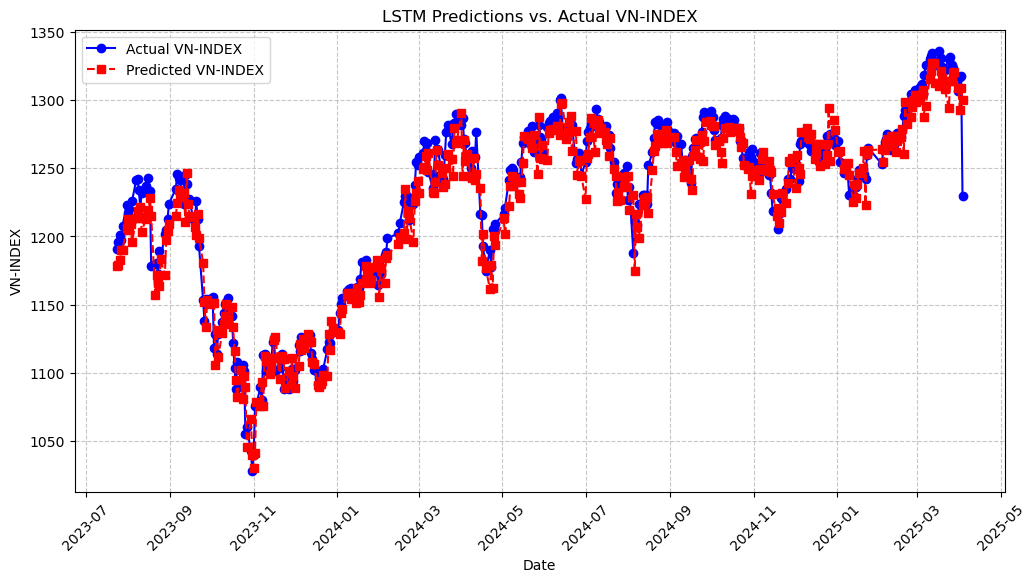

Predicted vs. Actual VN-INDEX (Test Set):
          Date  Actual VN-INDEX  Predicted VN-INDEX
0   2023-07-24      1190.719984         1178.660607
1   2023-07-25      1195.899982         1179.070558
2   2023-07-26      1200.839975         1182.886364
3   2023-07-27      1197.329994         1189.957193
4   2023-07-28      1207.670028         1189.921817
..         ...              ...                 ...
419 2025-03-28      1317.460022         1320.967768
420 2025-03-31      1306.860022         1308.658597
421 2025-04-01      1317.330000         1292.696706
422 2025-04-02      1317.829973         1308.682798
423 2025-04-03      1229.839993         1300.239684

[424 rows x 3 columns]


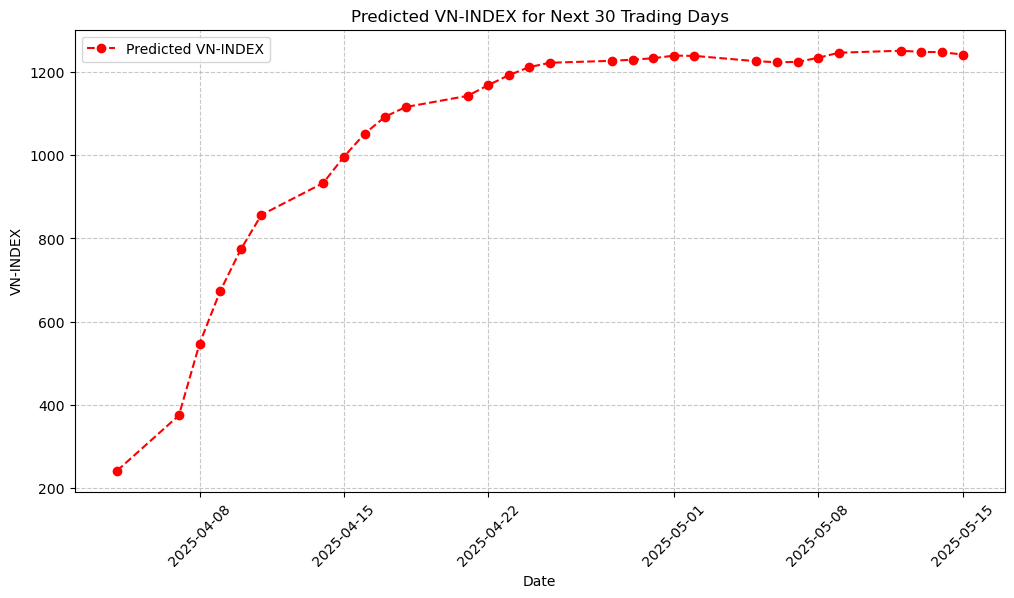

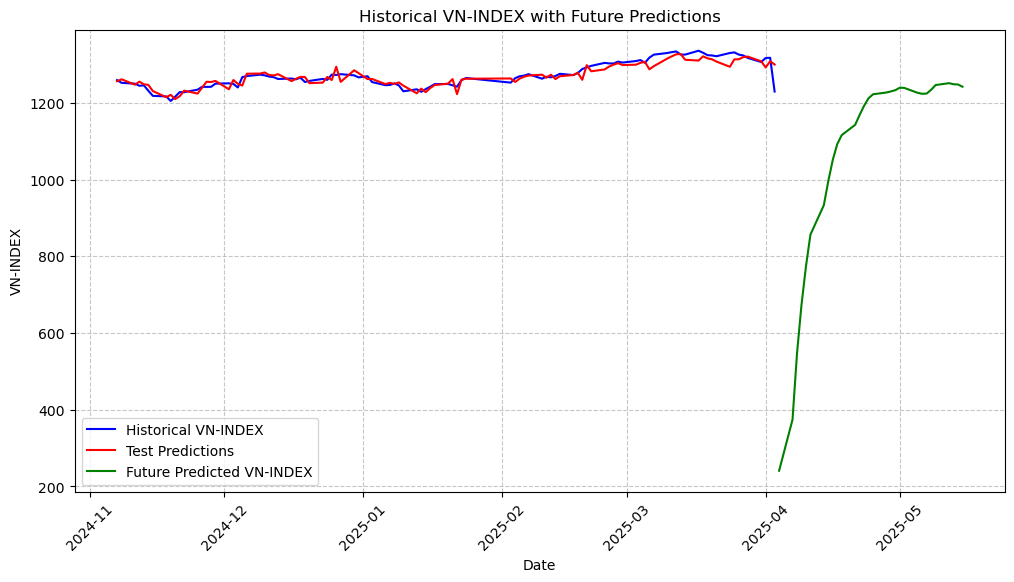

         Date  Predicted VN-INDEX
0  2025-04-04          241.108732
1  2025-04-07          374.196032
2  2025-04-08          546.536018
3  2025-04-09          672.948805
4  2025-04-10          773.506073
5  2025-04-11          856.614790
6  2025-04-14          933.456627
7  2025-04-15          996.404363
8  2025-04-16         1051.612199
9  2025-04-17         1092.844547
10 2025-04-18         1116.180087
11 2025-04-21         1143.042023
12 2025-04-22         1168.802356
13 2025-04-23         1192.808200
14 2025-04-24         1212.350670
15 2025-04-25         1222.707659
16 2025-04-28         1227.348532
17 2025-04-29         1230.147052
18 2025-04-30         1233.496258
19 2025-05-01         1239.910733
20 2025-05-02         1239.222009
21 2025-05-05         1226.389204
22 2025-05-06         1223.954007
23 2025-05-07         1224.631632
24 2025-05-08         1234.601330
25 2025-05-09         1246.824950
26 2025-05-12         1251.637850
27 2025-05-13         1248.841488
28 2025-05-14 

In [21]:
data = df_3

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = lstm_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

[I 2025-04-04 02:28:15,578] A new study created in memory with name: no-name-7cad4150-a60e-4abe-95fd-613d9fe6505a
[I 2025-04-04 02:29:25,497] Trial 0 finished with value: 0.0005592542505571225 and parameters: {'hidden_size': 64, 'num_layers': 2, 'dropout': 0.4342854602505607, 'learning_rate': 0.0015784581616267996, 'batch_size': 32}. Best is trial 0 with value: 0.0005592542505571225.
/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3449494595917327 and num_layers=1
  warnings.warn(
[I 2025-04-04 02:29:43,590] Trial 1 finished with value: 0.0006129019324248475 and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.3449494595917327, 'learning_rate': 0.004091797100098723, 'batch_size': 128}. Best is trial 0 with value: 0.0005592542505571225.
[I 2025-04-04 02:31:40,383] Trial 2 finished with value: 0.0006450

Best Hyperparameters: {'hidden_size': 256, 'num_layers': 1, 'dropout': 0.13383180546741677, 'learning_rate': 0.0015760620026503392, 'batch_size': 32}
Best Overall Average Training Loss: 0.0003
Final Evaluation Loss on Test Set: 0.0001
RMSE: 13.3942, MAE: 9.9250, R²: 0.9570, Directional Accuracy: 0.5107


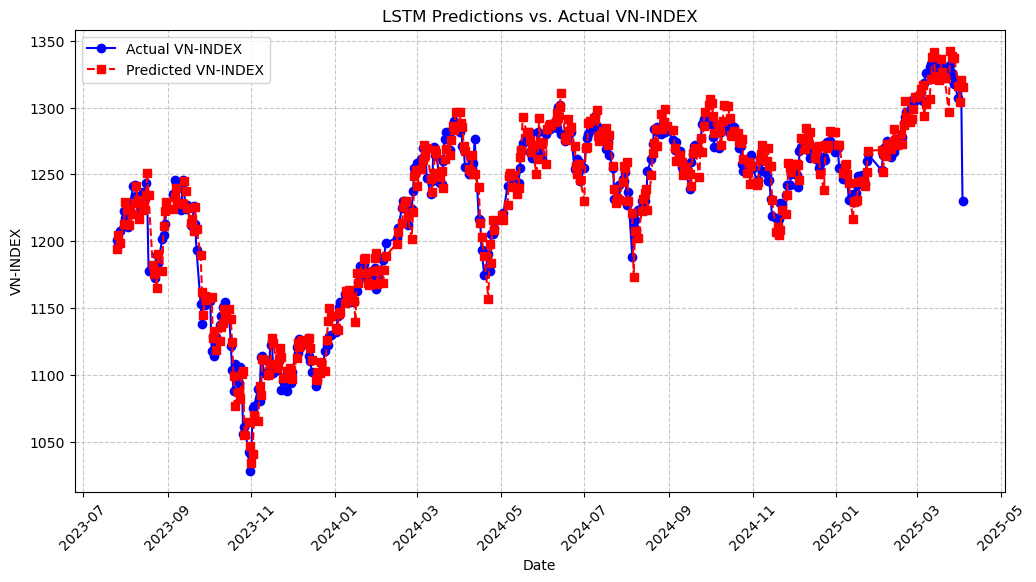

Predicted vs. Actual VN-INDEX (Test Set):
          Date  Actual VN-INDEX  Predicted VN-INDEX
0   2023-07-26      1200.839975         1194.285689
1   2023-07-27      1197.329994         1204.441055
2   2023-07-28      1207.670028         1198.668366
3   2023-07-31      1222.900034         1212.675378
4   2023-08-01      1217.560032         1229.337708
..         ...              ...                 ...
417 2025-03-28      1317.460022         1337.326739
418 2025-03-31      1306.860022         1315.885113
419 2025-04-01      1317.330000         1303.967935
420 2025-04-02      1317.829973         1320.729458
421 2025-04-03      1229.839993         1314.989448

[422 rows x 3 columns]


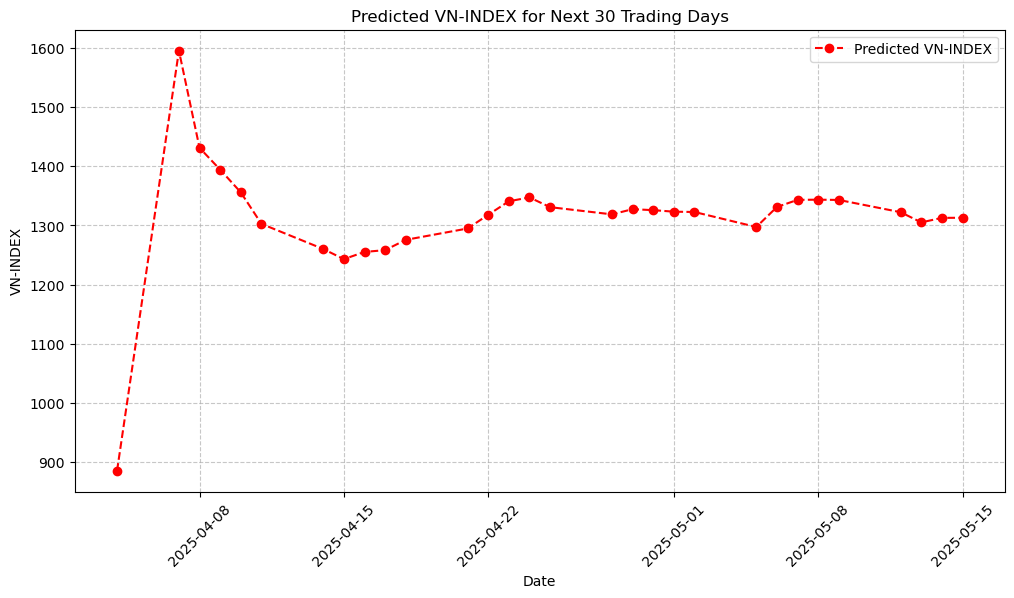

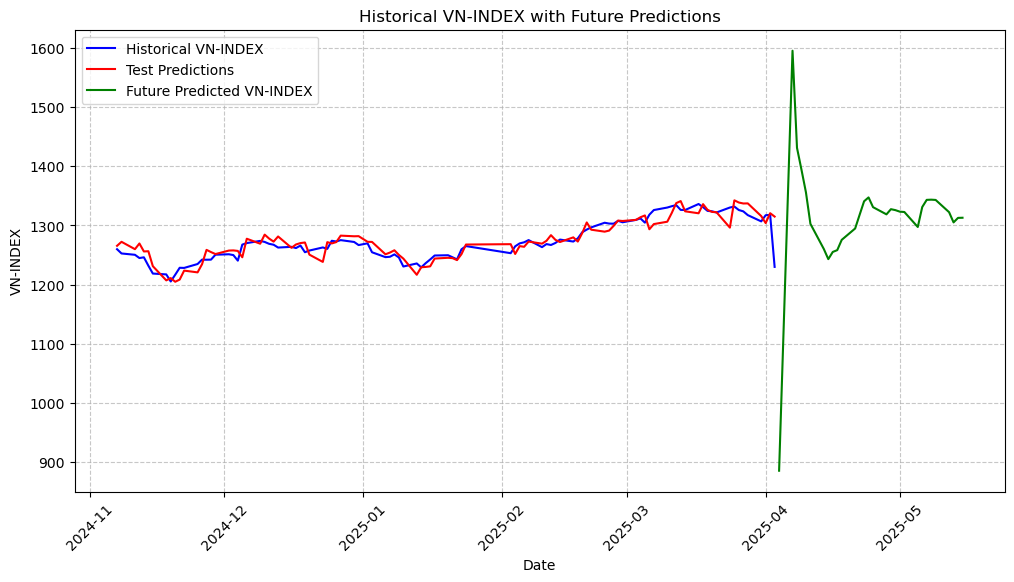

         Date  Predicted VN-INDEX
0  2025-04-04          884.844002
1  2025-04-07         1595.716133
2  2025-04-08         1431.362940
3  2025-04-09         1394.394115
4  2025-04-10         1356.033661
5  2025-04-11         1302.720740
6  2025-04-14         1260.101619
7  2025-04-15         1242.970222
8  2025-04-16         1255.153996
9  2025-04-17         1258.202078
10 2025-04-18         1275.614328
11 2025-04-21         1294.839103
12 2025-04-22         1318.019418
13 2025-04-23         1340.901615
14 2025-04-24         1347.442336
15 2025-04-25         1330.935077
16 2025-04-28         1318.757777
17 2025-04-29         1327.518354
18 2025-04-30         1325.886797
19 2025-05-01         1323.296913
20 2025-05-02         1322.756709
21 2025-05-05         1297.384516
22 2025-05-06         1331.179860
23 2025-05-07         1343.288179
24 2025-05-08         1343.614429
25 2025-05-09         1343.150758
26 2025-05-12         1322.421210
27 2025-05-13         1305.159406
28 2025-05-14 

In [22]:
data = lag_features_indicators(df_3, ['VN_Index_Close'])

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = lstm_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

/var/folders/fl/t1q3j3rn0dg278fhg2bvg0dw0000gn/T/ipykernel_88644/3744217377.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy_df[f'{col}_Lag{lag}'] = copy_df[col].shift(lag)
/var/folders/fl/t1q3j3rn0dg278fhg2bvg0dw0000gn/T/ipykernel_88644/3744217377.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy_df[f'{col}_Lag{lag}'] = copy_df[col].shift(lag)
/var/folders/fl/t1q3j3rn0dg278fhg2bvg0dw0000gn/T/ipykernel_88644/3744217377.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

Best Hyperparameters: {'hidden_size': 256, 'num_layers': 1, 'dropout': 0.25865748337429334, 'learning_rate': 0.0003182749292213132, 'batch_size': 32}
Best Overall Average Training Loss: 0.0003
Final Evaluation Loss on Test Set: 0.0003
RMSE: 21.8125, MAE: 17.1091, R²: 0.8875, Directional Accuracy: 0.5181


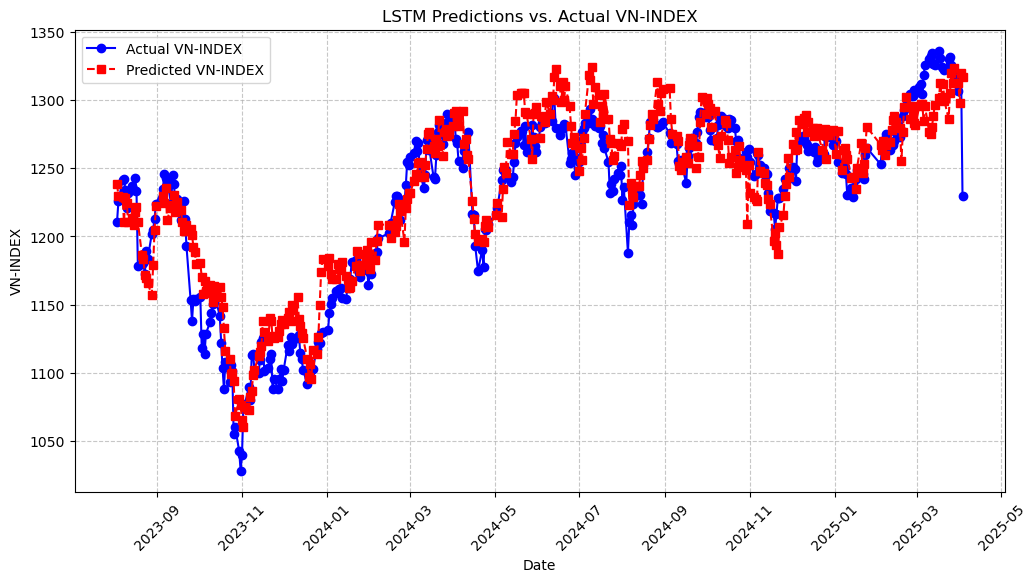

Predicted vs. Actual VN-INDEX (Test Set):
          Date  Actual VN-INDEX  Predicted VN-INDEX
0   2023-08-03      1210.950022         1238.591475
1   2023-08-04      1225.980024         1229.403066
2   2023-08-07      1241.419977         1229.283603
3   2023-08-08      1242.230014         1210.306232
4   2023-08-09      1233.989987         1228.329054
..         ...              ...                 ...
411 2025-03-28      1317.460022         1323.499923
412 2025-03-31      1306.860022         1312.810364
413 2025-04-01      1317.330000         1298.231393
414 2025-04-02      1317.829973         1320.278890
415 2025-04-03      1229.839993         1316.915117

[416 rows x 3 columns]


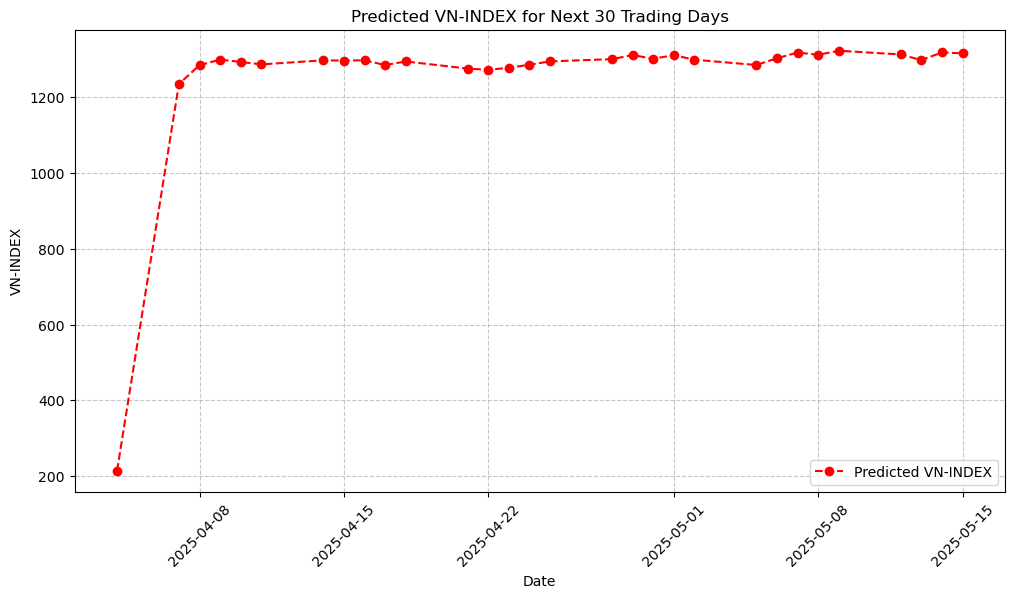

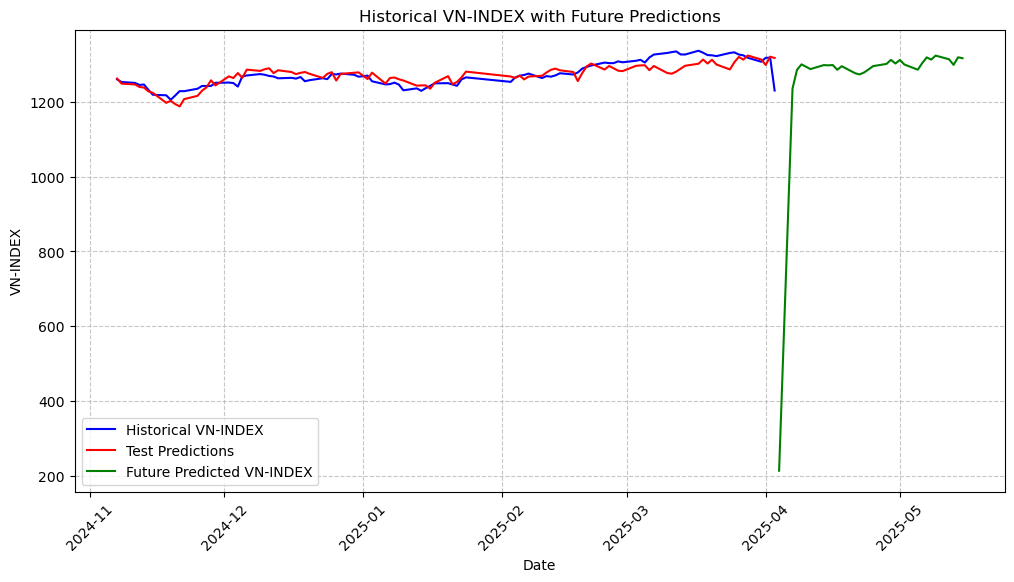

         Date  Predicted VN-INDEX
0  2025-04-04          213.934075
1  2025-04-07         1235.348861
2  2025-04-08         1285.061240
3  2025-04-09         1299.812469
4  2025-04-10         1293.598768
5  2025-04-11         1287.174119
6  2025-04-14         1297.858669
7  2025-04-15         1297.166553
8  2025-04-16         1297.987149
9  2025-04-17         1285.383559
10 2025-04-18         1294.867235
11 2025-04-21         1276.089098
12 2025-04-22         1272.918624
13 2025-04-23         1278.118892
14 2025-04-24         1286.214406
15 2025-04-25         1295.088049
16 2025-04-28         1300.996695
17 2025-04-29         1311.808492
18 2025-04-30         1302.066699
19 2025-05-01         1311.528101
20 2025-05-02         1299.438973
21 2025-05-05         1285.550885
22 2025-05-06         1303.240520
23 2025-05-07         1318.493956
24 2025-05-08         1312.457832
25 2025-05-09         1323.231016
26 2025-05-12         1313.340549
27 2025-05-13         1298.415829
28 2025-05-14 

In [23]:
data = lag_features_indicators(df_3, df_3.columns)

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = lstm_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

/var/folders/fl/t1q3j3rn0dg278fhg2bvg0dw0000gn/T/ipykernel_88644/3744217377.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy_df['Month'] = copy_df.index.month
/var/folders/fl/t1q3j3rn0dg278fhg2bvg0dw0000gn/T/ipykernel_88644/3744217377.py:69: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy_df[f'{col}_EMA_Ratio'] = copy_df[f'{col}_EMA_10'] / copy_df[f'{col}_EMA_20']
/var/folders/fl/t1q3j3rn0dg278fhg2bvg0dw0000gn/T/ipykernel_88644/3744217377.py:69: PerformanceWarning: DataFrame is highly fragmented.  This is usually the

Best Hyperparameters: {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.12955955462475127, 'learning_rate': 0.0022044541807826907, 'batch_size': 64}
Best Overall Average Training Loss: 0.0003
Final Evaluation Loss on Test Set: 0.0003
RMSE: 20.6518, MAE: 15.8162, R²: 0.8979, Directional Accuracy: 0.5439


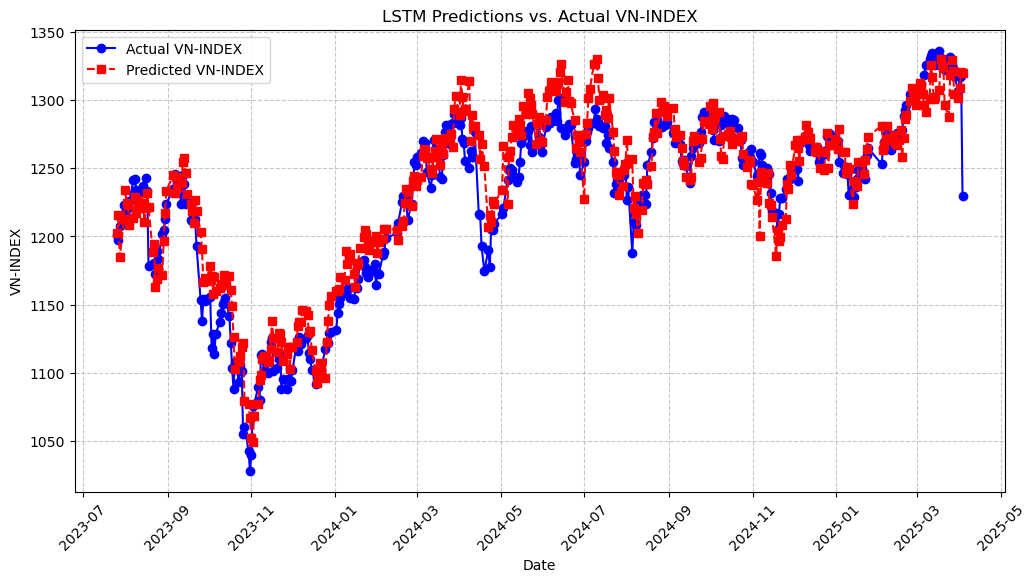

Predicted vs. Actual VN-INDEX (Test Set):
          Date  Actual VN-INDEX  Predicted VN-INDEX
0   2023-07-26      1200.839975         1202.894124
1   2023-07-27      1197.329994         1215.927241
2   2023-07-28      1207.670028         1184.987296
3   2023-07-31      1222.900034         1212.608325
4   2023-08-01      1217.560032         1234.033765
..         ...              ...                 ...
417 2025-03-28      1317.460022         1304.493188
418 2025-03-31      1306.860022         1301.911936
419 2025-04-01      1317.330000         1308.886810
420 2025-04-02      1317.829973         1320.799826
421 2025-04-03      1229.839993         1320.189947

[422 rows x 3 columns]


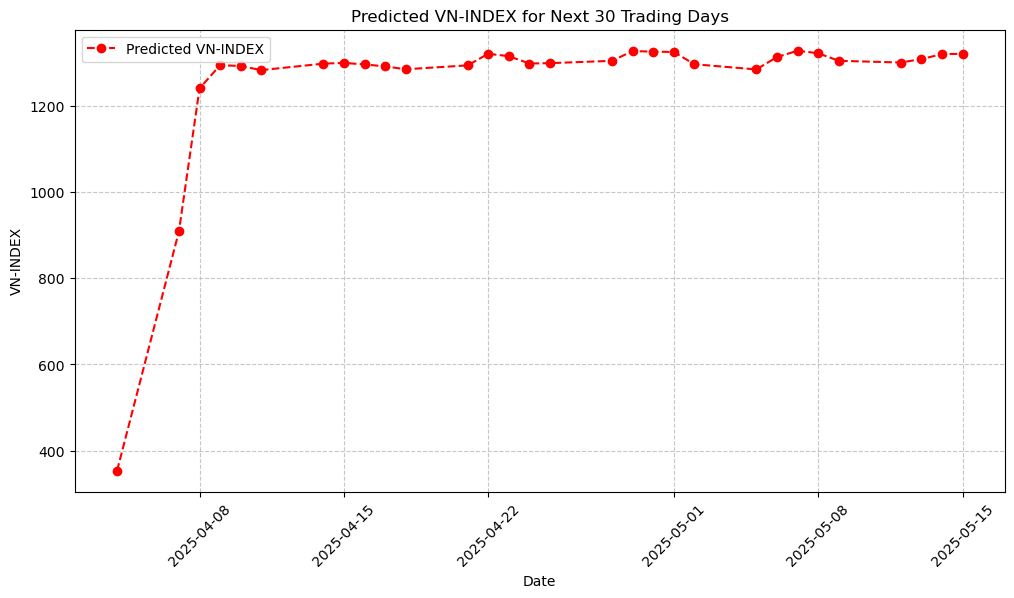

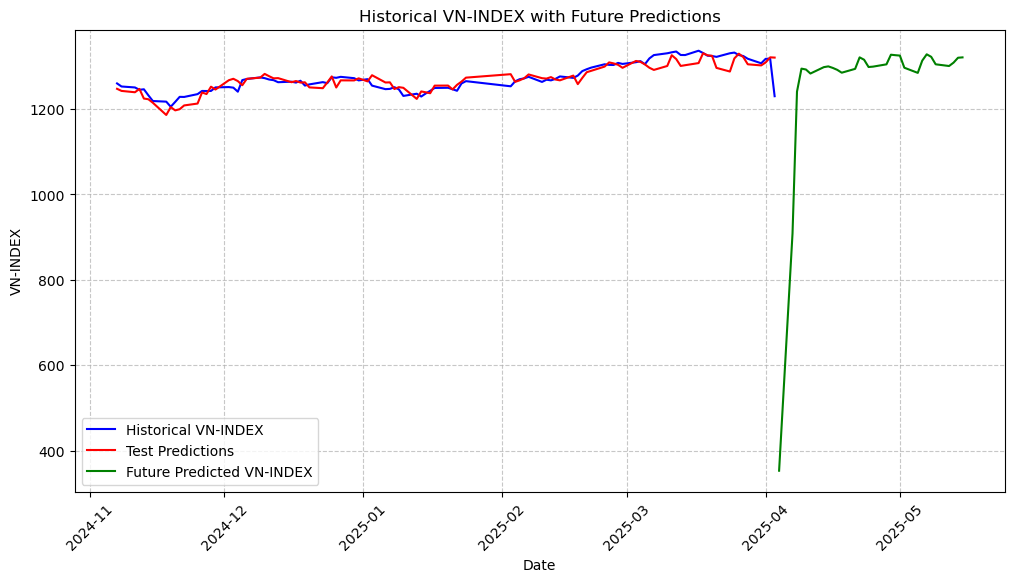

         Date  Predicted VN-INDEX
0  2025-04-04          353.530435
1  2025-04-07          908.650766
2  2025-04-08         1240.561461
3  2025-04-09         1294.363486
4  2025-04-10         1292.306794
5  2025-04-11         1282.881231
6  2025-04-14         1297.837165
7  2025-04-15         1299.616857
8  2025-04-16         1296.044448
9  2025-04-17         1291.492441
10 2025-04-18         1284.828326
11 2025-04-21         1293.816885
12 2025-04-22         1320.715970
13 2025-04-23         1315.175194
14 2025-04-24         1298.147461
15 2025-04-25         1299.037269
16 2025-04-28         1304.391374
17 2025-04-29         1326.936222
18 2025-04-30         1325.795080
19 2025-05-01         1324.889010
20 2025-05-02         1296.477367
21 2025-05-05         1284.413904
22 2025-05-06         1313.065398
23 2025-05-07         1327.834045
24 2025-05-08         1322.003243
25 2025-05-09         1304.478929
26 2025-05-12         1300.489478
27 2025-05-13         1308.377666
28 2025-05-14 

In [24]:
data = lag_features_indicators(df_3, df_1.columns)

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = lstm_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)

/var/folders/fl/t1q3j3rn0dg278fhg2bvg0dw0000gn/T/ipykernel_88644/3744217377.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy_df[f'{col}_Lag{lag}'] = copy_df[col].shift(lag)
/var/folders/fl/t1q3j3rn0dg278fhg2bvg0dw0000gn/T/ipykernel_88644/3744217377.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  copy_df[f'{col}_Lag{lag}'] = copy_df[col].shift(lag)
/var/folders/fl/t1q3j3rn0dg278fhg2bvg0dw0000gn/T/ipykernel_88644/3744217377.py:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of call

Best Hyperparameters: {'hidden_size': 256, 'num_layers': 3, 'dropout': 0.2096396833171569, 'learning_rate': 0.0005554789862307912, 'batch_size': 32}
Best Overall Average Training Loss: 0.0005
Final Evaluation Loss on Test Set: 0.0006
RMSE: 31.9332, MAE: 24.8641, R²: 0.7590, Directional Accuracy: 0.5157


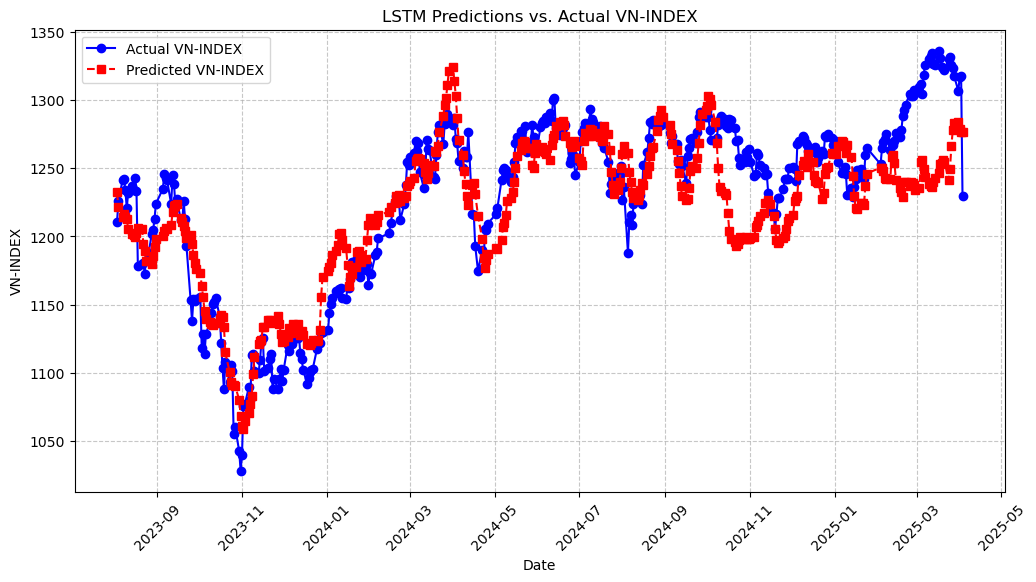

Predicted vs. Actual VN-INDEX (Test Set):
          Date  Actual VN-INDEX  Predicted VN-INDEX
0   2023-08-03      1210.950022         1232.327369
1   2023-08-04      1225.980024         1221.658465
2   2023-08-07      1241.419977         1214.639275
3   2023-08-08      1242.230014         1216.311990
4   2023-08-09      1233.989987         1213.935907
..         ...              ...                 ...
411 2025-03-28      1317.460022         1283.456966
412 2025-03-31      1306.860022         1284.297062
413 2025-04-01      1317.330000         1278.871124
414 2025-04-02      1317.829973         1276.699978
415 2025-04-03      1229.839993         1276.822987

[416 rows x 3 columns]


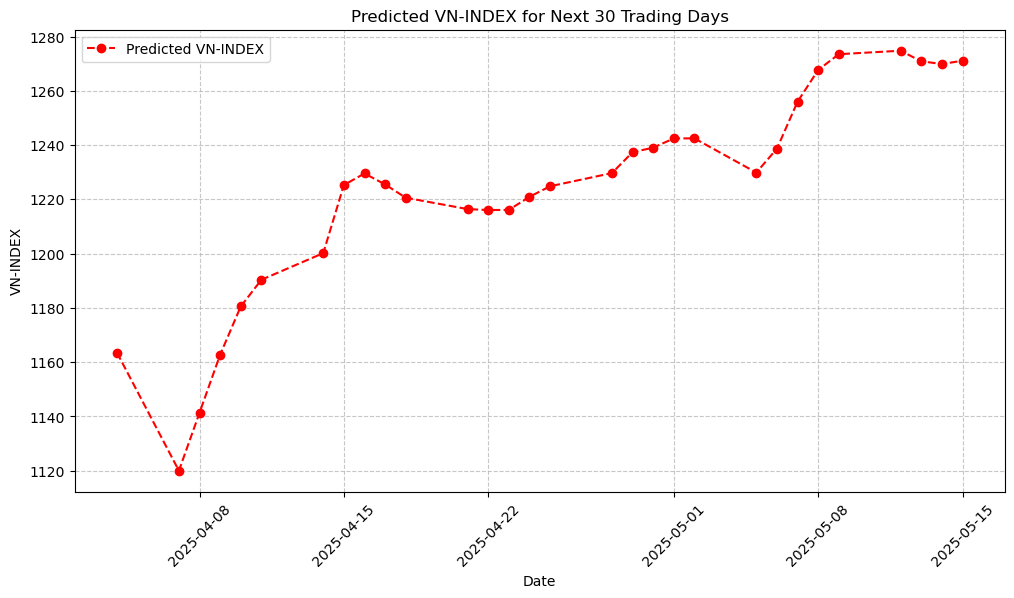

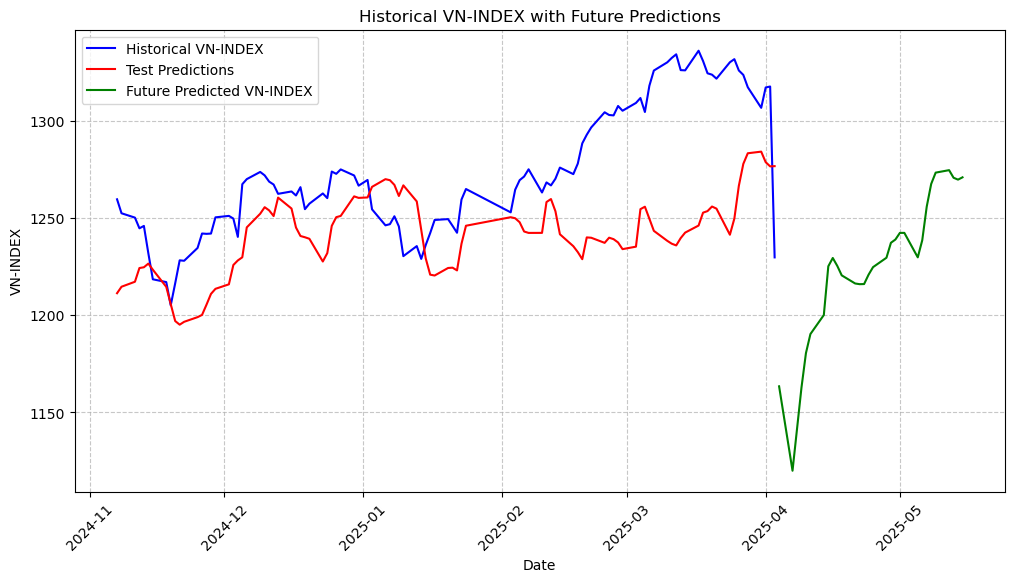

         Date  Predicted VN-INDEX
0  2025-04-04         1163.450717
1  2025-04-07         1119.991423
2  2025-04-08         1141.371158
3  2025-04-09         1162.755981
4  2025-04-10         1180.539800
5  2025-04-11         1190.360901
6  2025-04-14         1200.170365
7  2025-04-15         1225.260702
8  2025-04-16         1229.537173
9  2025-04-17         1225.481670
10 2025-04-18         1220.585147
11 2025-04-21         1216.406635
12 2025-04-22         1216.048323
13 2025-04-23         1216.111369
14 2025-04-24         1220.926118
15 2025-04-25         1224.820461
16 2025-04-28         1229.666887
17 2025-04-29         1237.365398
18 2025-04-30         1239.041350
19 2025-05-01         1242.451213
20 2025-05-02         1242.463699
21 2025-05-05         1229.861496
22 2025-05-06         1238.660764
23 2025-05-07         1255.963725
24 2025-05-08         1267.666254
25 2025-05-09         1273.484108
26 2025-05-12         1274.762518
27 2025-05-13         1270.850601
28 2025-05-14 

In [25]:
data = lag_features_indicators(df_3, df_2.columns)

# 🚀 Train the model and get the test set
model, X_test_tensor, scaler, y_pred = lstm_model_pipeline(data)

# 🔮 Generate future predictions
future_prediction(X_test_tensor, y_pred, data, scaler, model, num_days=30)